## What changed?
This notebook is better organized so that unlike the original ResNet-18 notebook, you only need to change parameters at the top of the second cell; the first cell still validates if CUDA is being used.

In [1]:
# Check if CUDA

import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"GPU count: {torch.cuda.device_count()}")

if torch.cuda.is_available():
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    print("❌ CUDA not detected by PyTorch")

PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA version: 12.1
GPU count: 1
GPU name: NVIDIA GeForce RTX 2060
GPU memory: 6.0 GB


In [ ]:
# Full multi-fold training
#   Complete Multi-Architecture Ensemble Training, Analysis, and Visualization Pipeline

import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import timm
import numpy as np
import cv2
import random
import json
import os
import glob
import pickle
from datetime import datetime
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# CONFIGURATION - Change model architectures here
AVAILABLE_ARCHITECTURES = ['resnet18', 'resnet34', 'resnet50', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'mobilenetv3_large_100']
AUGMENTATION_TARGET = 1200  # Target samples per class after augmentation
NUM_FOLDS = 5
IMAGE_SIZE = (224, 448)  # height, width

plt.style.use('default')
sns.set_palette("husl")

try:
    from torch.cuda.amp import autocast, GradScaler
    MIXED_PRECISION_AVAILABLE = True
except ImportError:
    MIXED_PRECISION_AVAILABLE = False
    class autocast:
        def __enter__(self):
            return self
        def __exit__(self, *args):
            pass

def load_original_data():
    try:
        fpath = "G:\\Dropbox\\AI Projects\\buck\\tooth_analysis\\images\\*.png"
        
        image_paths = glob.glob(fpath)
        if not image_paths:
            raise FileNotFoundError(f"No images found at {fpath}")
        
        images = []
        ages = []
        
        for img_path in image_paths:
            try:
                img = cv2.imread(img_path)
                if img is None:
                    continue
                
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img_resized = cv2.resize(img, IMAGE_SIZE[::-1])
                
                filename = os.path.basename(img_path)
                filename_no_ext = os.path.splitext(filename)[0]
                parts = filename_no_ext.split('_')
                
                if len(parts) < 3:
                    continue
                
                bbb_part = parts[1]
                
                if 'p' not in bbb_part:
                    continue
                
                value_str = bbb_part.replace('p', '.')
                try:
                    age_value = float(value_str)
                except ValueError:
                    continue
                
                images.append(img_resized)
                ages.append(age_value)
                
            except Exception as e:
                continue
        
        if not images:
            raise ValueError("No valid images loaded")
        
        ages_grouped = [5.5 if age >= 5.5 else age for age in ages]
        
        age_counts = Counter(ages_grouped)
        valid_ages = {age for age, count in age_counts.items() if count >= 3}
        
        filtered_images = []
        filtered_ages = []
        
        for img, age in zip(images, ages_grouped):
            if age in valid_ages:
                filtered_images.append(img)
                filtered_ages.append(age)
        
        return np.array(filtered_images), filtered_ages
        
    except Exception as e:
        print(f"Error loading data: {e}")
        raise

def enhanced_augment_image(image):
    if image.dtype != np.uint8:
        image = image.astype(np.uint8)
    
    if random.random() < 0.7:
        angle = random.uniform(-15, 15)
        h, w = image.shape[:2]
        M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1.0)
        image = cv2.warpAffine(image, M, (w, h))
    
    if random.random() < 0.5:
        image = cv2.flip(image, 1)
    
    if random.random() < 0.8:
        alpha = random.uniform(0.7, 1.3)
        beta = random.randint(-25, 25)
        image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    
    if random.random() < 0.4:
        gamma = random.uniform(0.8, 1.2)
        inv_gamma = 1.0 / gamma
        table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
        image = cv2.LUT(image, table)
    
    if random.random() < 0.3:
        noise = np.random.normal(0, 7, image.shape).astype(np.int16)
        image_int16 = image.astype(np.int16)
        noisy_image = np.clip(image_int16 + noise, 0, 255)
        image = noisy_image.astype(np.uint8)
    
    return image

def create_augmented_data(X_train, y_train):
    class_counts = Counter(y_train)
    max_count = max(class_counts.values())
    target_count = max(AUGMENTATION_TARGET, max_count)
    
    X_aug = []
    y_aug = []
    
    for class_idx in range(len(set(y_train))):
        class_mask = y_train == class_idx
        class_images = X_train[class_mask]
        current_count = len(class_images)
        
        if current_count == 0:
            continue
        
        for _ in range(4):
            X_aug.extend(class_images)
            y_aug.extend([class_idx] * current_count)
        
        needed = target_count - (current_count * 4)
        for i in range(needed):
            orig_idx = random.randint(0, current_count - 1)
            aug_img = enhanced_augment_image(class_images[orig_idx].copy())
            X_aug.append(aug_img)
            y_aug.append(class_idx)
    
    return np.array(X_aug), np.array(y_aug)

class OptimizedDataset(Dataset):
    def __init__(self, X, y, test_time_aug=False):
        self.X = torch.FloatTensor(X if isinstance(X, np.ndarray) else np.array(X))
        self.y = torch.LongTensor(y if isinstance(y, np.ndarray) else np.array(y))
        self.test_time_aug = test_time_aug
        self.mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        self.std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        image = self.X[idx].clone()
        label = self.y[idx].clone()
        
        if image.max() > 1.0:
            image = image / 255.0
        
        if len(image.shape) == 3 and image.shape[-1] == 3:
            image = image.permute(2, 0, 1)
        
        if image.shape[-2:] != IMAGE_SIZE:
            image = F.interpolate(image.unsqueeze(0), size=IMAGE_SIZE, mode='bilinear', align_corners=False).squeeze(0)
        
        if self.test_time_aug and random.random() < 0.5:
            image = torch.flip(image, [2])
        
        image = (image - self.mean) / self.std
        return image, label

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.handles = []
        
        handle1 = self.target_layer.register_forward_hook(self.forward_hook)
        handle2 = self.target_layer.register_backward_hook(self.backward_hook)
        self.handles.extend([handle1, handle2])
    
    def forward_hook(self, module, input, output):
        self.activations = output.detach()
    
    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
    
    def remove_hooks(self):
        for handle in self.handles:
            handle.remove()
        self.handles = []
    
    def generate_cam(self, input_image, class_idx):
        self.model.eval()
        
        device = next(self.model.parameters()).device
        input_image = input_image.to(device)
        
        input_image.requires_grad_()
        output = self.model(input_image)
        
        self.model.zero_grad()
        
        class_score = output[:, class_idx]
        class_score.backward()
        
        if self.gradients is None or self.activations is None:
            return np.zeros(IMAGE_SIZE)
        
        gradients = self.gradients[0].to(device)
        activations = self.activations[0].to(device)
        
        weights = torch.mean(gradients, dim=(1, 2))
        
        cam = torch.zeros(activations.shape[1:], dtype=torch.float32, device=device)
        for i, w in enumerate(weights):
            cam += w * activations[i]
        
        cam = F.relu(cam)
        
        if cam.max() > 0:
            cam = cam / cam.max()
        
        return cam.detach().cpu().numpy()

class MultiArchEnsembleTrainer:
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        if torch.cuda.is_available():
            torch.backends.cudnn.benchmark = True
            if MIXED_PRECISION_AVAILABLE:
                self.scaler = GradScaler()
                self.use_amp = True
            else:
                self.use_amp = False
        else:
            self.use_amp = False
    
    def create_model(self, architecture):
        model = timm.create_model(architecture, pretrained=True, num_classes=self.num_classes)
        
        if 'resnet' in architecture:
            frozen_layers = ['conv1', 'bn1', 'layer1', 'layer2', 'layer3']
            for name, param in model.named_parameters():
                for frozen_layer in frozen_layers:
                    if name.startswith(frozen_layer):
                        param.requires_grad = False
                        break
        elif 'efficientnet' in architecture:
            for name, param in model.named_parameters():
                if 'blocks.0' in name or 'blocks.1' in name or 'blocks.2' in name:
                    param.requires_grad = False
        elif 'mobilenet' in architecture:
            for name, param in model.named_parameters():
                if 'features.0' in name or 'features.1' in name or 'features.2' in name:
                    param.requires_grad = False
        
        if hasattr(model, 'fc'):
            in_features = model.fc.in_features
            model.fc = nn.Sequential(
                nn.Dropout(0.3),
                nn.Linear(in_features, self.num_classes)
            )
        elif hasattr(model, 'classifier'):
            if hasattr(model.classifier, 'in_features'):
                in_features = model.classifier.in_features
                model.classifier = nn.Sequential(
                    nn.Dropout(0.3),
                    nn.Linear(in_features, self.num_classes)
                )
            else:
                in_features = model.classifier[-1].in_features
                model.classifier[-1] = nn.Sequential(
                    nn.Dropout(0.3),
                    nn.Linear(in_features, self.num_classes)
                )
        
        return model.to(self.device)
    
    def train_single_model(self, train_loader, val_loader, architecture):
        model = self.create_model(architecture)
        
        criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
        
        backbone_params = []
        classifier_params = []
        
        for name, param in model.named_parameters():
            if param.requires_grad:
                if 'fc' in name or 'classifier' in name:
                    classifier_params.append(param)
                else:
                    backbone_params.append(param)
        
        optimizer = optim.AdamW([
            {'params': backbone_params, 'lr': 0.0003},
            {'params': classifier_params, 'lr': 0.001}
        ], weight_decay=0.03)
        
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=80, eta_min=1e-6)
        
        max_epochs = 80
        patience = 20
        best_val_acc = 0.0
        patience_counter = 0
        best_state = None
        
        training_history = {
            'train_accs': [],
            'val_accs': [],
            'train_losses': [],
            'val_losses': []
        }
        
        for epoch in range(max_epochs):
            model.train()
            train_correct = 0
            train_total = 0
            train_loss_total = 0.0
            train_batches = 0
            
            for batch_idx, (images, labels) in enumerate(train_loader):
                images, labels = images.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                
                if self.use_amp:
                    with autocast():
                        outputs = model(images)
                        loss = criterion(outputs, labels)
                    self.scaler.scale(loss).backward()
                    self.scaler.step(optimizer)
                    self.scaler.update()
                else:
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                
                _, predicted = torch.max(outputs, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()
                train_loss_total += loss.item()
                train_batches += 1
                
                if batch_idx % 10 == 0 and torch.cuda.is_available():
                    torch.cuda.empty_cache()
            
            train_acc = 100 * train_correct / train_total
            train_loss = train_loss_total / train_batches
            
            model.eval()
            val_correct = 0
            val_total = 0
            val_loss_total = 0.0
            val_batches = 0
            
            with torch.no_grad():
                for batch_idx, (images, labels) in enumerate(val_loader):
                    images, labels = images.to(self.device), labels.to(self.device)
                    
                    if self.use_amp:
                        with autocast():
                            outputs = model(images)
                            loss = criterion(outputs, labels)
                    else:
                        outputs = model(images)
                        loss = criterion(outputs, labels)
                    
                    _, predicted = torch.max(outputs, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
                    val_loss_total += loss.item()
                    val_batches += 1
                    
                    if batch_idx % 5 == 0 and torch.cuda.is_available():
                        torch.cuda.empty_cache()
            
            val_acc = 100 * val_correct / val_total
            val_loss = val_loss_total / val_batches
            scheduler.step()
            
            training_history['train_accs'].append(train_acc)
            training_history['val_accs'].append(val_acc)
            training_history['train_losses'].append(train_loss)
            training_history['val_losses'].append(val_loss)
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                best_state = model.state_dict().copy()
            else:
                patience_counter += 1
            
            if patience_counter >= patience:
                break
            
            if epoch % 10 == 0 and torch.cuda.is_available():
                torch.cuda.empty_cache()
        
        if best_state is not None:
            model.load_state_dict(best_state)
        
        return model, best_val_acc, training_history, architecture
    
    def train_single_fold(self, train_loader, val_loader, fold_idx):
        best_model = None
        best_acc = 0.0
        best_history = None
        best_arch = None
        
        for arch in AVAILABLE_ARCHITECTURES:
            try:
                print(f"  Testing {arch}...")
                model, val_acc, history, architecture = self.train_single_model(train_loader, val_loader, arch)
                
                if val_acc > best_acc:
                    best_acc = val_acc
                    best_model = model
                    best_history = history
                    best_arch = architecture
                
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                    
            except Exception as e:
                print(f"  Failed to train {arch}: {e}")
                continue
        
        return best_model, best_acc, best_history, best_arch
    
    def train_ensemble(self, images, ages):
        if not isinstance(images, np.ndarray):
            images = np.array(images)
        if not isinstance(ages, np.ndarray):
            ages = np.array(ages)
        
        unique_ages = sorted(list(set(ages)))
        label_mapping = {age: i for i, age in enumerate(unique_ages)}
        y_indices = np.array([label_mapping[age] for age in ages])
        
        skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
        
        trained_models = []
        cv_scores = []
        training_histories = []
        architectures_used = []
        
        for fold, (train_idx, val_idx) in enumerate(skf.split(images, y_indices)):
            print(f"Training Fold {fold + 1}/{NUM_FOLDS}")
            
            X_train_fold = images[train_idx]
            y_train_fold = y_indices[train_idx]
            X_val_fold = images[val_idx]
            y_val_fold = y_indices[val_idx]
            
            X_train_aug, y_train_aug = create_augmented_data(X_train_fold, y_train_fold)
            
            train_dataset = OptimizedDataset(X_train_aug, y_train_aug)
            val_dataset = OptimizedDataset(X_val_fold, y_val_fold, test_time_aug=True)
            
            batch_size = 16 if torch.cuda.is_available() else 8
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
            
            model, val_acc, history, best_arch = self.train_single_fold(train_loader, val_loader, fold + 1)
            
            if model is not None:
                trained_models.append(model)
                cv_scores.append(val_acc)
                training_histories.append(history)
                architectures_used.append(best_arch)
                print(f"Fold {fold + 1}/{NUM_FOLDS} completed: {val_acc:.1f}% with {best_arch}")
            
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        
        return trained_models, cv_scores, label_mapping, training_histories, architectures_used
    
    def evaluate_model_with_tta(self, model, test_loader):
        model.eval()
        all_predictions = []
        all_probabilities = []
        all_labels = []
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                
                outputs1 = model(images)
                flipped = torch.flip(images, [3])
                outputs2 = model(flipped)
                
                avg_outputs = (outputs1 + outputs2) / 2
                probs = F.softmax(avg_outputs, dim=1)
                _, predicted = torch.max(avg_outputs, 1)
                
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                all_predictions.extend(predicted.cpu().numpy())
                all_probabilities.extend(probs.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        accuracy = 100 * correct / total
        return accuracy, all_predictions, all_probabilities, all_labels
    
    def evaluate_ensemble(self, models, cv_scores, test_loader):
        scores_array = np.array(cv_scores)
        weights = np.exp(scores_array / 20)
        weights = weights / weights.sum()
        
        for model in models:
            model.eval()
        
        test_correct = 0
        test_total = 0
        all_ensemble_probs = []
        all_labels = []
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                
                ensemble_outputs = torch.zeros(images.size(0), self.num_classes).to(self.device)
                
                for model, weight in zip(models, weights):
                    outputs1 = model(images)
                    flipped = torch.flip(images, [3])
                    outputs2 = model(flipped)
                    avg_outputs = (outputs1 + outputs2) / 2
                    
                    ensemble_outputs += weight * F.softmax(avg_outputs, dim=1)
                
                _, predicted = torch.max(ensemble_outputs, 1)
                
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
                
                all_ensemble_probs.extend(ensemble_outputs.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        ensemble_acc = 100 * test_correct / test_total
        
        return ensemble_acc, np.array(all_ensemble_probs), np.array(all_labels)

class ModelAnalyzer:
    def __init__(self, models, cv_scores, label_mapping, X_test, y_test, training_histories, architectures_used):
        self.models = models
        self.cv_scores = cv_scores
        self.label_mapping = label_mapping
        self.X_test = X_test
        self.y_test = y_test
        self.training_histories = training_histories
        self.architectures_used = architectures_used
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.unique_ages = sorted(list(label_mapping.keys()))
        self.num_classes = len(self.unique_ages)
        
        Path("analysis_plots").mkdir(exist_ok=True)
    
    def evaluate_individual_models(self):
        test_dataset = OptimizedDataset(self.X_test, self.y_test, test_time_aug=True)
        batch_size = 16 if torch.cuda.is_available() else 8
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
        
        trainer = MultiArchEnsembleTrainer(self.num_classes)
        individual_results = []
        
        for i, model in enumerate(self.models):
            accuracy, preds, probs, labels = trainer.evaluate_model_with_tta(model, test_loader)
            
            individual_results.append({
                'model_name': f'{self.architectures_used[i]}_Fold_{i+1}',
                'accuracy': accuracy,
                'cv_score': self.cv_scores[i],
                'architecture': self.architectures_used[i],
                'predictions': np.array(preds),
                'probabilities': np.array(probs),
                'true_labels': np.array(labels)
            })
        
        return individual_results
    
    def evaluate_ensemble(self, individual_results):
        test_dataset = OptimizedDataset(self.X_test, self.y_test, test_time_aug=True)
        batch_size = 16 if torch.cuda.is_available() else 8
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
        
        trainer = MultiArchEnsembleTrainer(self.num_classes)
        ensemble_acc, ensemble_probs, true_labels = trainer.evaluate_ensemble(self.models, self.cv_scores, test_loader)
        
        ensemble_preds = np.argmax(ensemble_probs, axis=1)
        
        return {
            'ensemble_accuracy': ensemble_acc,
            'ensemble_predictions': ensemble_preds,
            'ensemble_probabilities': ensemble_probs,
            'true_labels': true_labels
        }
    
    def calculate_metrics(self, individual_results, ensemble_result):
        metrics = {}
        
        for i, result in enumerate(individual_results):
            preds = result['predictions']
            true_labels = result['true_labels']
            
            accuracy = np.mean(preds == true_labels) * 100
            f1_macro = f1_score(true_labels, preds, average='macro', zero_division=0) * 100
            f1_weighted = f1_score(true_labels, preds, average='weighted', zero_division=0) * 100
            precision = precision_score(true_labels, preds, average='macro', zero_division=0) * 100
            recall = recall_score(true_labels, preds, average='macro', zero_division=0) * 100
            
            metrics[f'model_{i+1}'] = {
                'accuracy': accuracy,
                'f1_macro': f1_macro,
                'f1_weighted': f1_weighted,
                'precision': precision,
                'recall': recall,
                'cv_score': result['cv_score'],
                'architecture': result['architecture']
            }
        
        if ensemble_result:
            ensemble_preds = ensemble_result['ensemble_predictions']
            true_labels = ensemble_result['true_labels']
            
            ensemble_accuracy = np.mean(ensemble_preds == true_labels) * 100
            ensemble_f1_macro = f1_score(true_labels, ensemble_preds, average='macro', zero_division=0) * 100
            ensemble_f1_weighted = f1_score(true_labels, ensemble_preds, average='weighted', zero_division=0) * 100
            ensemble_precision = precision_score(true_labels, ensemble_preds, average='macro', zero_division=0) * 100
            ensemble_recall = recall_score(true_labels, ensemble_preds, average='macro', zero_division=0) * 100
            
            metrics['ensemble'] = {
                'accuracy': ensemble_accuracy,
                'f1_macro': ensemble_f1_macro,
                'f1_weighted': ensemble_f1_weighted,
                'precision': ensemble_precision,
                'recall': ensemble_recall
            }
            
            class_names = [f'Age {age}' for age in self.unique_ages]
            metrics['classification_report'] = classification_report(
                true_labels, ensemble_preds,
                output_dict=True,
                zero_division=0
            )
            metrics['class_names'] = class_names
        
        return metrics
    
    def create_performance_plots(self, individual_results, ensemble_result, metrics):
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        model_names = [f'{result["architecture"]}\n(Fold {i+1})' for i, result in enumerate(individual_results)]
        accuracies = [result['accuracy'] for result in individual_results]
        cv_scores = [result['cv_score'] for result in individual_results]
        
        if ensemble_result:
            model_names.append('Ensemble')
            accuracies.append(ensemble_result['ensemble_accuracy'])
            cv_scores.append(np.mean(cv_scores))
        
        colors = plt.cm.Set3(np.linspace(0, 1, len(model_names)))
        
        bars = ax1.bar(model_names, accuracies, alpha=0.8, color=colors, edgecolor='black', linewidth=2)
        ax1.axhline(y=70, color='red', linestyle='--', linewidth=2, label="Target: 70%")
        
        for bar, acc in zip(bars, accuracies):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')
        
        ax1.set_ylabel('Test Accuracy (%)')
        ax1.set_title('Model Performance Comparison')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.tick_params(axis='x', rotation=45)
        
        test_accs = [result['accuracy'] for result in individual_results]
        cv_accs = [result['cv_score'] for result in individual_results]
        
        ax2.scatter(cv_accs, test_accs, alpha=0.7, s=100, c=colors[:-1] if ensemble_result else colors)
        
        min_acc = min(min(cv_accs), min(test_accs)) - 5
        max_acc = max(max(cv_accs), max(test_accs)) + 5
        ax2.plot([min_acc, max_acc], [min_acc, max_acc], 'k--', alpha=0.5)
        
        ax2.set_xlabel('Cross-Validation Accuracy (%)')
        ax2.set_ylabel('Test Accuracy (%)')
        ax2.set_title('CV vs Test Performance')
        ax2.grid(True, alpha=0.3)
        
        f1_scores = [metrics[f'model_{i+1}']['f1_macro'] for i in range(len(individual_results))]
        if ensemble_result and 'ensemble' in metrics:
            f1_scores.append(metrics['ensemble']['f1_macro'])
        
        ax3.bar(model_names, f1_scores, alpha=0.7, color='lightgreen', edgecolor='darkgreen')
        ax3.set_ylabel('F1 Score (%)')
        ax3.set_title('F1 Score (Macro) Comparison')
        ax3.grid(True, alpha=0.3)
        ax3.tick_params(axis='x', rotation=45)
        
        if ensemble_result:
            true_labels = ensemble_result['true_labels']
            ensemble_preds = ensemble_result['ensemble_predictions']
            class_names = [f'Age {age}' for age in self.unique_ages]
            
            true_dist = [np.sum(true_labels == i) for i in range(len(class_names))]
            pred_dist = [np.sum(ensemble_preds == i) for i in range(len(class_names))]
            
            x = np.arange(len(class_names))
            width = 0.35
            
            ax4.bar(x - width/2, true_dist, width, label='True Distribution', alpha=0.7, color='skyblue')
            ax4.bar(x + width/2, pred_dist, width, label='Predicted Distribution', alpha=0.7, color='salmon')
            
            ax4.set_xlabel('Age Class')
            ax4.set_ylabel('Number of Samples')
            ax4.set_title('True vs Predicted Distribution')
            ax4.set_xticks(x)
            ax4.set_xticklabels(class_names)
            ax4.legend()
            ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('analysis_plots/performance_overview.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def create_confusion_matrix(self, ensemble_result):
        if not ensemble_result:
            return
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        true_labels = ensemble_result['true_labels']
        ensemble_preds = ensemble_result['ensemble_predictions']
        class_names = [f'Age {age}' for age in self.unique_ages]
        
        cm = confusion_matrix(true_labels, ensemble_preds)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
                   xticklabels=class_names, yticklabels=class_names,
                   cbar_kws={'label': 'Number of Samples'})
        ax1.set_title('Confusion Matrix (Counts)')
        ax1.set_xlabel('Predicted Age Class')
        ax1.set_ylabel('True Age Class')
        
        cm_norm = confusion_matrix(true_labels, ensemble_preds, normalize='true')
        sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Greens', ax=ax2,
                   xticklabels=class_names, yticklabels=class_names,
                   cbar_kws={'label': 'Proportion'})
        ax2.set_title('Confusion Matrix (Normalized)')
        ax2.set_xlabel('Predicted Age Class')
        ax2.set_ylabel('True Age Class')
        
        plt.tight_layout()
        plt.savefig('analysis_plots/confusion_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def create_training_curves(self):
        fig, axes = plt.subplots(1, NUM_FOLDS, figsize=(4*NUM_FOLDS, 4))
        if NUM_FOLDS == 1:
            axes = [axes]
        
        for fold, history in enumerate(self.training_histories):
            ax = axes[fold]
            epochs = range(1, len(history['train_accs']) + 1)
            
            ax.plot(epochs, history['train_accs'], 'b-', label='Training', linewidth=2, alpha=0.8)
            ax.plot(epochs, history['val_accs'], 'r-', label='Validation', linewidth=2, alpha=0.8)
            
            ax.set_xlabel('Epoch')
            ax.set_ylabel('Accuracy (%)')
            ax.set_title(f'Fold {fold + 1} ({self.architectures_used[fold]})')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('analysis_plots/training_curves.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def run_analysis(self):
        individual_results = self.evaluate_individual_models()
        ensemble_result = self.evaluate_ensemble(individual_results)
        metrics = self.calculate_metrics(individual_results, ensemble_result)
        
        self.create_performance_plots(individual_results, ensemble_result, metrics)
        self.create_confusion_matrix(ensemble_result)
        self.create_training_curves()
        
        return individual_results, ensemble_result, metrics

class GradCAMVisualizer:
    def __init__(self, models, label_mapping, X_test, y_test, architectures_used):
        self.models = models
        self.label_mapping = label_mapping
        self.X_test = X_test
        self.y_test = y_test
        self.architectures_used = architectures_used
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.unique_ages = sorted(list(label_mapping.keys()))
        self.num_classes = len(self.unique_ages)
        
        Path("gradcam_visualizations").mkdir(exist_ok=True)
    
    def preprocess_image(self, image):
        if isinstance(image, np.ndarray):
            image = torch.FloatTensor(image)
        
        if image.max() > 1.0:
            image = image / 255.0
        
        if len(image.shape) == 3 and image.shape[-1] == 3:
            image = image.permute(2, 0, 1)
        
        if image.shape[-2:] != IMAGE_SIZE:
            image = F.interpolate(image.unsqueeze(0), size=IMAGE_SIZE, 
                                mode='bilinear', align_corners=False).squeeze(0)
        
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        image = (image - mean) / std
        
        return image.unsqueeze(0).to(self.device)
    
    def get_target_layer(self, model, architecture):
        if 'resnet' in architecture:
            return model.layer4[-1].conv2
        elif 'efficientnet' in architecture:
            return model.features[-1]
        elif 'mobilenet' in architecture:
            return model.features[-1]
        else:
            return model.features[-1] if hasattr(model, 'features') else model.layer4[-1]
    
    def overlay_heatmap(self, image, heatmap, alpha=0.6):
        heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
        
        heatmap_colored = cv2.applyColorMap(
            (heatmap_resized * 255).astype(np.uint8), 
            cv2.COLORMAP_JET
        )
        heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
        heatmap_colored = heatmap_colored.astype(np.float32) / 255.0
        
        if image.max() <= 1.0:
            image_display = image
        else:
            image_display = image.astype(np.float32) / 255.0
        
        overlaid = alpha * heatmap_colored + (1 - alpha) * image_display
        return overlaid
    
    def select_diverse_samples(self, num_samples):
        selected_indices = []
        
        for class_idx in range(self.num_classes):
            class_indices = np.where(np.array(self.y_test) == class_idx)[0]
            if len(class_indices) > 0:
                selected_indices.append(np.random.choice(class_indices))
        
        remaining_needed = num_samples - len(selected_indices)
        if remaining_needed > 0:
            available_indices = [i for i in range(len(self.y_test)) if i not in selected_indices]
            additional = np.random.choice(available_indices, 
                                        min(remaining_needed, len(available_indices)), 
                                        replace=False)
            selected_indices.extend(additional)
        
        return selected_indices[:num_samples]
    
    def visualize_model_attention(self, num_samples=6):
        sample_indices = self.select_diverse_samples(num_samples)
        
        num_cols = 2 + len(self.models)
        fig, axes = plt.subplots(num_samples, num_cols, figsize=(4*num_cols, 4*num_samples))
        
        if num_samples == 1:
            axes = axes.reshape(1, -1)
        
        grad_cams = []
        
        for i, (model, arch) in enumerate(zip(self.models, self.architectures_used)):
            try:
                target_layer = self.get_target_layer(model, arch)
                grad_cam = GradCAM(model, target_layer)
                grad_cams.append(grad_cam)
            except Exception as e:
                grad_cams.append(None)
        
        try:
            for sample_idx, idx in enumerate(sample_indices):
                original_image = self.X_test[idx]
                true_label = self.y_test[idx]
                true_age = self.unique_ages[true_label]
                
                input_tensor = self.preprocess_image(original_image.copy())
                
                if original_image.max() > 1.0:
                    display_image = original_image.astype(np.float32) / 255.0
                else:
                    display_image = original_image.astype(np.float32)
                
                axes[sample_idx, 0].imshow(display_image)
                axes[sample_idx, 0].set_title(f'Original\nTrue: Age {true_age}', fontsize=10)
                axes[sample_idx, 0].axis('off')
                
                model_heatmaps = []
                
                for model_idx, (model, grad_cam, arch) in enumerate(zip(self.models, grad_cams, self.architectures_used)):
                    if grad_cam is None:
                        axes[sample_idx, model_idx + 1].text(0.5, 0.5, 'Failed', 
                                                           transform=axes[sample_idx, model_idx + 1].transAxes,
                                                           ha='center', va='center')
                        axes[sample_idx, model_idx + 1].axis('off')
                        model_heatmaps.append(None)
                        continue
                    
                    try:
                        with torch.no_grad():
                            model_output = model(input_tensor)
                            model_pred = torch.argmax(model_output, dim=1).item()
                        
                        heatmap = grad_cam.generate_cam(input_tensor.clone(), model_pred)
                        model_heatmaps.append(heatmap)
                        
                        overlaid = self.overlay_heatmap(display_image, heatmap)
                        
                        axes[sample_idx, model_idx + 1].imshow(overlaid)
                        axes[sample_idx, model_idx + 1].set_title(f'{arch}\nPred: Age {self.unique_ages[model_pred]}', fontsize=9)
                        axes[sample_idx, model_idx + 1].axis('off')
                        
                    except Exception as e:
                        axes[sample_idx, model_idx + 1].text(0.5, 0.5, 'Error', 
                                                           transform=axes[sample_idx, model_idx + 1].transAxes,
                                                           ha='center', va='center')
                        axes[sample_idx, model_idx + 1].axis('off')
                        model_heatmaps.append(None)
                
                valid_heatmaps = [h for h in model_heatmaps if h is not None]
                if valid_heatmaps:
                    ensemble_heatmap = np.mean(valid_heatmaps, axis=0)
                    ensemble_overlaid = self.overlay_heatmap(display_image, ensemble_heatmap)
                    
                    axes[sample_idx, -1].imshow(ensemble_overlaid)
                    axes[sample_idx, -1].set_title(f'Ensemble\nAverage', fontsize=10)
                    axes[sample_idx, -1].axis('off')
                else:
                    axes[sample_idx, -1].text(0.5, 0.5, 'No Valid\nHeatmaps', 
                                            transform=axes[sample_idx, -1].transAxes,
                                            ha='center', va='center')
                    axes[sample_idx, -1].axis('off')
                
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
        
        finally:
            for grad_cam in grad_cams:
                if grad_cam is not None:
                    grad_cam.remove_hooks()
        
        plt.tight_layout()
        plt.savefig('gradcam_visualizations/multi_arch_ensemble_attention.png', 
                   dpi=300, bbox_inches='tight')
        plt.show()
    
    def run_gradcam_analysis(self):
        self.visualize_model_attention(num_samples=6)

def save_models_and_ensemble(models, cv_scores, label_mapping, ensemble_acc, training_histories, architectures_used):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    save_dir = f"multi_arch_ensemble_{timestamp}"
    os.makedirs(save_dir, exist_ok=True)
    
    for i, (model, score, arch) in enumerate(zip(models, cv_scores, architectures_used)):
        model_path = os.path.join(save_dir, f"{arch}_fold_{i+1}_{score:.1f}pct.pth")
        torch.save({
            'model_state_dict': model.state_dict(),
            'model_architecture': arch,
            'fold': i+1,
            'cv_score': score,
            'num_classes': len(label_mapping),
            'label_mapping': label_mapping,
            'input_size': IMAGE_SIZE
        }, model_path)
    
    ensemble_path = os.path.join(save_dir, "multi_arch_ensemble.pth")
    torch.save({
        'model_state_dicts': [model.state_dict() for model in models],
        'architectures_used': architectures_used,
        'cv_scores': cv_scores,
        'ensemble_score': ensemble_acc,
        'num_classes': len(label_mapping),
        'label_mapping': label_mapping,
        'input_size': IMAGE_SIZE
    }, ensemble_path)
    
    with open(os.path.join(save_dir, "training_histories.pkl"), 'wb') as f:
        pickle.dump(training_histories, f)
    
    metadata = {
        'timestamp': timestamp,
        'architectures_used': architectures_used,
        'num_folds': len(models),
        'cv_scores': cv_scores,
        'cv_mean': float(np.mean(cv_scores)),
        'cv_std': float(np.std(cv_scores)),
        'ensemble_score': ensemble_acc,
        'label_mapping': label_mapping,
        'input_size': f'{IMAGE_SIZE[1]}x{IMAGE_SIZE[0]}',
        'augmentation_target': AUGMENTATION_TARGET
    }
    
    with open(os.path.join(save_dir, "metadata.json"), 'w') as f:
        json.dump(metadata, f, indent=2)
    
    return save_dir

def main():
    print("Multi-Architecture Ensemble Training, Analysis, and Visualization Pipeline")
    print("=" * 80)
    print(f"Available architectures: {AVAILABLE_ARCHITECTURES}")
    print(f"Number of folds: {NUM_FOLDS}")
    print(f"Image size: {IMAGE_SIZE[1]}x{IMAGE_SIZE[0]}")
    print(f"Augmentation target: {AUGMENTATION_TARGET} samples per class")
    
    start_time = time.time()
    
    try:
        print("Loading data...")
        images, ages = load_original_data()
        
        trainer = MultiArchEnsembleTrainer(num_classes=len(set(ages)))
        
        print("Training ensemble...")
        models, cv_scores, label_mapping, training_histories, architectures_used = trainer.train_ensemble(images, ages)
        
        y_indices = np.array([label_mapping[age] for age in ages])
        X_train_all, X_test, y_train_all, y_test = train_test_split(
            images, y_indices, test_size=0.2, random_state=42, stratify=y_indices
        )
        
        test_dataset = OptimizedDataset(X_test, y_test, test_time_aug=True)
        batch_size = 32 if torch.cuda.is_available() else 8
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
        
        ensemble_acc, _, _ = trainer.evaluate_ensemble(models, cv_scores, test_loader)
        
        print("Saving models...")
        save_dir = save_models_and_ensemble(models, cv_scores, label_mapping, ensemble_acc, training_histories, architectures_used)
        
        elapsed = (time.time() - start_time) / 60
        
        print("\nTraining Results:")
        for i, (score, arch) in enumerate(zip(cv_scores, architectures_used)):
            print(f"Fold {i+1}: {score:.1f}% ({arch})")
        print(f"CV Mean: {np.mean(cv_scores):.1f}% ± {np.std(cv_scores):.1f}%")
        print(f"Ensemble Test Accuracy: {ensemble_acc:.1f}%")
        print(f"Training Time: {elapsed:.1f} minutes")
        print(f"Models saved to: {save_dir}")
        
        print("\nRunning model analysis...")
        analyzer = ModelAnalyzer(models, cv_scores, label_mapping, X_test, y_test, training_histories, architectures_used)
        individual_results, ensemble_result, metrics = analyzer.run_analysis()
        
        print("\nRunning Grad-CAM visualization...")
        gradcam_viz = GradCAMVisualizer(models, label_mapping, X_test, y_test, architectures_used)
        gradcam_viz.run_gradcam_analysis()
        
        print("\nPipeline Complete!")
        print("Check 'analysis_plots/' for performance analysis")
        print("Check 'gradcam_visualizations/' for attention maps")
        
        return {
            'models': models,
            'cv_scores': cv_scores,
            'ensemble_score': ensemble_acc,
            'architectures_used': architectures_used,
            'save_directory': save_dir
        }
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

In [3]:
# Resume Training Script - Continue from where training stopped

import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import timm
import numpy as np
import cv2
import random
import json
import os
import glob
import pickle
from datetime import datetime
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# CONFIGURATION - Should match your original training
AVAILABLE_ARCHITECTURES = ['resnet18', 'resnet34', 'resnet50', 'efficientnet_b0', 'mobilenetv3_large_100']
AUGMENTATION_TARGET = 1200
NUM_FOLDS = 5
IMAGE_SIZE = (224, 448)
BATCH_SIZE_TRAIN = 64
BATCH_SIZE_TEST = 96
NUM_WORKERS = 4

plt.style.use('default')
sns.set_palette("husl")

try:
    from torch.cuda.amp import autocast, GradScaler
    MIXED_PRECISION_AVAILABLE = True
except ImportError:
    MIXED_PRECISION_AVAILABLE = False
    class autocast:
        def __enter__(self):
            return self
        def __exit__(self, *args):
            pass

def load_original_data():
    try:
        fpath = "G:\\Dropbox\\AI Projects\\buck\\tooth_analysis\\images\\*.png"
        
        image_paths = glob.glob(fpath)
        if not image_paths:
            raise FileNotFoundError(f"No images found at {fpath}")
        
        images = []
        ages = []
        
        for img_path in image_paths:
            try:
                img = cv2.imread(img_path)
                if img is None:
                    continue
                
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img_resized = cv2.resize(img, IMAGE_SIZE[::-1])
                
                filename = os.path.basename(img_path)
                filename_no_ext = os.path.splitext(filename)[0]
                parts = filename_no_ext.split('_')
                
                if len(parts) < 3:
                    continue
                
                bbb_part = parts[1]
                
                if 'p' not in bbb_part:
                    continue
                
                value_str = bbb_part.replace('p', '.')
                try:
                    age_value = float(value_str)
                except ValueError:
                    continue
                
                images.append(img_resized)
                ages.append(age_value)
                
            except Exception as e:
                continue
        
        if not images:
            raise ValueError("No valid images loaded")
        
        ages_grouped = [5.5 if age >= 5.5 else age for age in ages]
        
        age_counts = Counter(ages_grouped)
        valid_ages = {age for age, count in age_counts.items() if count >= 3}
        
        filtered_images = []
        filtered_ages = []
        
        for img, age in zip(images, ages_grouped):
            if age in valid_ages:
                filtered_images.append(img)
                filtered_ages.append(age)
        
        return np.array(filtered_images), filtered_ages
        
    except Exception as e:
        print(f"Error loading data: {e}")
        raise

def enhanced_augment_image(image):
    if image.dtype != np.uint8:
        image = image.astype(np.uint8)
    
    if random.random() < 0.7:
        angle = random.uniform(-15, 15)
        h, w = image.shape[:2]
        M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1.0)
        image = cv2.warpAffine(image, M, (w, h))
    
    if random.random() < 0.5:
        image = cv2.flip(image, 1)
    
    if random.random() < 0.8:
        alpha = random.uniform(0.7, 1.3)
        beta = random.randint(-25, 25)
        image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    
    if random.random() < 0.4:
        gamma = random.uniform(0.8, 1.2)
        inv_gamma = 1.0 / gamma
        table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
        image = cv2.LUT(image, table)
    
    if random.random() < 0.3:
        noise = np.random.normal(0, 7, image.shape).astype(np.int16)
        image_int16 = image.astype(np.int16)
        noisy_image = np.clip(image_int16 + noise, 0, 255)
        image = noisy_image.astype(np.uint8)
    
    return image

def create_augmented_data(X_train, y_train):
    class_counts = Counter(y_train)
    max_count = max(class_counts.values())
    target_count = max(AUGMENTATION_TARGET, max_count)
    
    X_aug = []
    y_aug = []
    
    for class_idx in range(len(set(y_train))):
        class_mask = y_train == class_idx
        class_images = X_train[class_mask]
        current_count = len(class_images)
        
        if current_count == 0:
            continue
        
        for _ in range(4):
            X_aug.extend(class_images)
            y_aug.extend([class_idx] * current_count)
        
        needed = target_count - (current_count * 4)
        for i in range(needed):
            orig_idx = random.randint(0, current_count - 1)
            aug_img = enhanced_augment_image(class_images[orig_idx].copy())
            X_aug.append(aug_img)
            y_aug.append(class_idx)
    
    return np.array(X_aug), np.array(y_aug)

class OptimizedDataset(Dataset):
    def __init__(self, X, y, test_time_aug=False):
        self.X = torch.FloatTensor(X if isinstance(X, np.ndarray) else np.array(X))
        self.y = torch.LongTensor(y if isinstance(y, np.ndarray) else np.array(y))
        self.test_time_aug = test_time_aug
        self.mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        self.std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        image = self.X[idx].clone()
        label = self.y[idx].clone()
        
        if image.max() > 1.0:
            image = image / 255.0
        
        if len(image.shape) == 3 and image.shape[-1] == 3:
            image = image.permute(2, 0, 1)
        
        if image.shape[-2:] != IMAGE_SIZE:
            image = F.interpolate(image.unsqueeze(0), size=IMAGE_SIZE, mode='bilinear', align_corners=False).squeeze(0)
        
        if self.test_time_aug and random.random() < 0.5:
            image = torch.flip(image, [2])
        
        image = (image - self.mean) / self.std
        return image, label

class MultiArchEnsembleTrainer:
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        if torch.cuda.is_available():
            torch.backends.cudnn.benchmark = True
            torch.backends.cudnn.deterministic = False
            if MIXED_PRECISION_AVAILABLE:
                self.scaler = GradScaler()
                self.use_amp = True
            else:
                self.use_amp = False
        else:
            self.use_amp = False
        
        print(f"Using device: {self.device}")
        if torch.cuda.is_available():
            print(f"GPU: {torch.cuda.get_device_name()}")
            print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    
    def create_model(self, architecture):
        model = timm.create_model(architecture, pretrained=True, num_classes=self.num_classes)
        
        if 'resnet' in architecture:
            frozen_layers = ['conv1', 'bn1', 'layer1', 'layer2', 'layer3']
            for name, param in model.named_parameters():
                for frozen_layer in frozen_layers:
                    if name.startswith(frozen_layer):
                        param.requires_grad = False
                        break
        elif 'efficientnet' in architecture:
            for name, param in model.named_parameters():
                if 'blocks.0' in name or 'blocks.1' in name or 'blocks.2' in name:
                    param.requires_grad = False
        elif 'mobilenet' in architecture:
            for name, param in model.named_parameters():
                if 'features.0' in name or 'features.1' in name or 'features.2' in name:
                    param.requires_grad = False
        
        if hasattr(model, 'fc'):
            in_features = model.fc.in_features
            model.fc = nn.Sequential(
                nn.Dropout(0.3),
                nn.Linear(in_features, self.num_classes)
            )
        elif hasattr(model, 'classifier'):
            if hasattr(model.classifier, 'in_features'):
                in_features = model.classifier.in_features
                model.classifier = nn.Sequential(
                    nn.Dropout(0.3),
                    nn.Linear(in_features, self.num_classes)
                )
            else:
                in_features = model.classifier[-1].in_features
                model.classifier[-1] = nn.Sequential(
                    nn.Dropout(0.3),
                    nn.Linear(in_features, self.num_classes)
                )
        
        return model.to(self.device)
    
    def train_single_model(self, train_loader, val_loader, architecture):
        model = self.create_model(architecture)
        
        criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
        
        backbone_params = []
        classifier_params = []
        
        for name, param in model.named_parameters():
            if param.requires_grad:
                if 'fc' in name or 'classifier' in name:
                    classifier_params.append(param)
                else:
                    backbone_params.append(param)
        
        optimizer = optim.AdamW([
            {'params': backbone_params, 'lr': 0.0003},
            {'params': classifier_params, 'lr': 0.001}
        ], weight_decay=0.03)
        
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=80, eta_min=1e-6)
        
        max_epochs = 80
        patience = 20
        best_val_acc = 0.0
        patience_counter = 0
        best_state = None
        
        training_history = {
            'train_accs': [],
            'val_accs': [],
            'train_losses': [],
            'val_losses': []
        }
        
        for epoch in range(max_epochs):
            model.train()
            train_correct = 0
            train_total = 0
            train_loss_total = 0.0
            train_batches = 0
            
            for batch_idx, (images, labels) in enumerate(train_loader):
                images, labels = images.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                
                if self.use_amp:
                    with autocast():
                        outputs = model(images)
                        loss = criterion(outputs, labels)
                    self.scaler.scale(loss).backward()
                    self.scaler.step(optimizer)
                    self.scaler.update()
                else:
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                
                _, predicted = torch.max(outputs, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()
                train_loss_total += loss.item()
                train_batches += 1
            
            train_acc = 100 * train_correct / train_total
            train_loss = train_loss_total / train_batches
            
            model.eval()
            val_correct = 0
            val_total = 0
            val_loss_total = 0.0
            val_batches = 0
            
            with torch.no_grad():
                for batch_idx, (images, labels) in enumerate(val_loader):
                    images, labels = images.to(self.device), labels.to(self.device)
                    
                    if self.use_amp:
                        with autocast():
                            outputs = model(images)
                            loss = criterion(outputs, labels)
                    else:
                        outputs = model(images)
                        loss = criterion(outputs, labels)
                    
                    _, predicted = torch.max(outputs, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
                    val_loss_total += loss.item()
                    val_batches += 1
            
            val_acc = 100 * val_correct / val_total
            val_loss = val_loss_total / val_batches
            scheduler.step()
            
            training_history['train_accs'].append(train_acc)
            training_history['val_accs'].append(val_acc)
            training_history['train_losses'].append(train_loss)
            training_history['val_losses'].append(val_loss)
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                best_state = model.state_dict().copy()
            else:
                patience_counter += 1
            
            if patience_counter >= patience:
                break
        
        if best_state is not None:
            model.load_state_dict(best_state)
        
        return model, best_val_acc, training_history, architecture
    
    def train_single_fold(self, train_loader, val_loader, fold_idx):
        best_model = None
        best_acc = 0.0
        best_history = None
        best_arch = None
        
        for arch in AVAILABLE_ARCHITECTURES:
            try:
                print(f"  Testing {arch}...")
                model, val_acc, history, architecture = self.train_single_model(train_loader, val_loader, arch)
                
                if val_acc > best_acc:
                    best_acc = val_acc
                    best_model = model
                    best_history = history
                    best_arch = architecture
                
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                    
            except Exception as e:
                print(f"  Failed to train {arch}: {e}")
                continue
        
        return best_model, best_acc, best_history, best_arch

def find_existing_models(save_dir=None):
    """Find existing model files from previous training"""
    if save_dir is None:
        # Find the most recent save directory
        dirs = [d for d in os.listdir('.') if d.startswith('multi_arch_ensemble_')]
        if not dirs:
            return None, [], [], [], [], [], {}
        save_dir = max(dirs, key=lambda x: os.path.getctime(x))
    
    if not os.path.exists(save_dir):
        return None, [], [], [], [], [], {}
    
    print(f"Found existing training directory: {save_dir}")
    
    # Load metadata
    metadata_path = os.path.join(save_dir, "metadata.json")
    if os.path.exists(metadata_path):
        with open(metadata_path, 'r') as f:
            metadata = json.load(f)
        print(f"Loaded metadata: {metadata}")
    else:
        metadata = None
    
    # Find existing model files
    model_files = glob.glob(os.path.join(save_dir, "*_fold_*.pth"))
    model_files = [f for f in model_files if 'ensemble' not in f]
    
    models = []
    cv_scores = []
    architectures_used = []
    training_histories = []
    completed_folds = []
    label_mapping = {}
    
    # Load training histories if available
    history_path = os.path.join(save_dir, "training_histories.pkl")
    if os.path.exists(history_path):
        with open(history_path, 'rb') as f:
            training_histories = pickle.load(f)
    
    for model_file in sorted(model_files):
        try:
            checkpoint = torch.load(model_file, map_location='cpu')
            fold_num = checkpoint['fold']
            architecture = checkpoint['model_architecture']
            cv_score = checkpoint['cv_score']
            num_classes = checkpoint['num_classes']
            model_label_mapping = checkpoint.get('label_mapping', {})
            
            # Use the first model's label mapping as reference
            if not label_mapping and model_label_mapping:
                label_mapping = model_label_mapping
            
            # Create and load model
            trainer = MultiArchEnsembleTrainer(num_classes)
            model = trainer.create_model(architecture)
            model.load_state_dict(checkpoint['model_state_dict'])
            
            models.append(model)
            cv_scores.append(cv_score)
            architectures_used.append(architecture)
            completed_folds.append(fold_num)
            
            print(f"Loaded Fold {fold_num}: {cv_score:.1f}% ({architecture})")
            
        except Exception as e:
            print(f"Failed to load {model_file}: {e}")
            continue
    
    return save_dir, models, cv_scores, architectures_used, training_histories, completed_folds, label_mapping

def resume_training():
    print("Resume Training Script")
    print("=" * 50)
    
    # Find existing models
    try:
        result = find_existing_models()
        save_dir, models, cv_scores, architectures_used, training_histories, completed_folds, label_mapping = result
        
        print(f"Search result: save_dir={save_dir}, found {len(models)} models")
        
        if not models:
            print("No existing models found. Please run the main training script first.")
            print("Looking for directories starting with 'multi_arch_ensemble_'")
            dirs = [d for d in os.listdir('.') if d.startswith('multi_arch_ensemble_')]
            print(f"Found directories: {dirs}")
            return
            
    except Exception as e:
        print(f"Error finding existing models: {e}")
        import traceback
        traceback.print_exc()
        return
    
    print(f"Found {len(models)} completed folds: {completed_folds}")
    
    # Determine which folds are missing
    all_folds = set(range(1, NUM_FOLDS + 1))
    missing_folds = all_folds - set(completed_folds)
    
    if not missing_folds:
        print("All folds are complete! Proceeding with analysis...")
    else:
        print(f"Missing folds: {sorted(missing_folds)}")
        
        # Load data
        print("Loading data...")
        images, ages = load_original_data()
        
        # Recreate label mapping if not available or empty
        if not label_mapping:
            unique_ages = sorted(list(set(ages)))
            label_mapping = {age: i for i, age in enumerate(unique_ages)}
            print("Recreated label mapping from data")
        else:
            print("Using existing label mapping")
        
        y_indices = np.array([label_mapping[age] for age in ages])
        
        # Recreate the same train/test split using the same random state
        X_train_all, X_test, y_train_all, y_test = train_test_split(
            images, y_indices, test_size=0.2, random_state=42, stratify=y_indices
        )
        
        # Recreate the same fold splits
        skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
        fold_splits = list(skf.split(X_train_all, y_train_all))
        
        trainer = MultiArchEnsembleTrainer(len(label_mapping))
        
        # Train missing folds
        for missing_fold in sorted(missing_folds):
            print(f"\nTraining missing Fold {missing_fold}/{NUM_FOLDS}")
            
            fold_idx = missing_fold - 1  # Convert to 0-based index
            train_idx, val_idx = fold_splits[fold_idx]
            
            X_train_fold = X_train_all[train_idx]
            y_train_fold = y_train_all[train_idx]
            X_val_fold = X_train_all[val_idx]
            y_val_fold = y_train_all[val_idx]
            
            X_train_aug, y_train_aug = create_augmented_data(X_train_fold, y_train_fold)
            
            train_dataset = OptimizedDataset(X_train_aug, y_train_aug)
            val_dataset = OptimizedDataset(X_val_fold, y_val_fold, test_time_aug=True)
            
            train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True, num_workers=NUM_WORKERS)
            val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE_TEST, shuffle=False, num_workers=NUM_WORKERS)
            
            model, val_acc, history, best_arch = trainer.train_single_fold(train_loader, val_loader, missing_fold)
            
            if model is not None:
                models.append(model)
                cv_scores.append(val_acc)
                architectures_used.append(best_arch)
                training_histories.append(history)
                completed_folds.append(missing_fold)
                
                # Save the new model immediately
                model_path = os.path.join(save_dir, f"{best_arch}_fold_{missing_fold}_{val_acc:.1f}pct.pth")
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'model_architecture': best_arch,
                    'fold': missing_fold,
                    'cv_score': val_acc,
                    'num_classes': len(label_mapping),
                    'label_mapping': label_mapping,
                    'input_size': IMAGE_SIZE
                }, model_path)
                
                print(f"Fold {missing_fold} completed: {val_acc:.1f}% with {best_arch}")
                print(f"Saved to: {model_path}")
            
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        
        # Update training histories
        history_path = os.path.join(save_dir, "training_histories.pkl")
        with open(history_path, 'wb') as f:
            pickle.dump(training_histories, f)
    
    # Now proceed with ensemble evaluation and analysis
    print("\nAll folds complete! Running ensemble evaluation...")
    
    # Load test data and ensure we have label mapping
    images, ages = load_original_data()
    
    if not label_mapping:
        unique_ages = sorted(list(set(ages)))
        label_mapping = {age: i for i, age in enumerate(unique_ages)}
        print("Recreated label mapping for final evaluation")
    
    y_indices = np.array([label_mapping[age] for age in ages])
    X_train_all, X_test, y_train_all, y_test = train_test_split(
        images, y_indices, test_size=0.2, random_state=42, stratify=y_indices
    )
    
    # Create ensemble and evaluate
    trainer = MultiArchEnsembleTrainer(len(label_mapping))
    
    test_dataset = OptimizedDataset(X_test, y_test, test_time_aug=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE_TEST, shuffle=False, num_workers=NUM_WORKERS)
    
    ensemble_acc, _, _ = trainer.evaluate_ensemble(models, cv_scores, test_loader)
    
    # Update and save ensemble
    ensemble_path = os.path.join(save_dir, "multi_arch_ensemble.pth")
    torch.save({
        'model_state_dicts': [model.state_dict() for model in models],
        'architectures_used': architectures_used,
        'cv_scores': cv_scores,
        'ensemble_score': ensemble_acc,
        'num_classes': len(label_mapping),
        'label_mapping': label_mapping,
        'input_size': IMAGE_SIZE
    }, ensemble_path)
    
    # Update metadata
    metadata = {
        'timestamp': datetime.now().strftime("%Y%m%d_%H%M%S"),
        'architectures_used': architectures_used,
        'num_folds': len(models),
        'cv_scores': cv_scores,
        'cv_mean': float(np.mean(cv_scores)),
        'cv_std': float(np.std(cv_scores)),
        'ensemble_score': ensemble_acc,
        'label_mapping': label_mapping,
        'input_size': f'{IMAGE_SIZE[1]}x{IMAGE_SIZE[0]}',
        'augmentation_target': AUGMENTATION_TARGET,
        'completed': True
    }
    
    with open(os.path.join(save_dir, "metadata.json"), 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print("\nFinal Results:")
    for i, (score, arch) in enumerate(zip(cv_scores, architectures_used)):
        print(f"Fold {i+1}: {score:.1f}% ({arch})")
    print(f"CV Mean: {np.mean(cv_scores):.1f}% ± {np.std(cv_scores):.1f}%")
    print(f"Ensemble Test Accuracy: {ensemble_acc:.1f}%")
    print(f"Results saved to: {save_dir}")
    
    return {
        'models': models,
        'cv_scores': cv_scores,
        'ensemble_score': ensemble_acc,
        'architectures_used': architectures_used,
        'save_directory': save_dir,
        'label_mapping': label_mapping
    }

if __name__ == "__main__":
    resume_training()

Resume Training Script
Search result: save_dir=None, found 0 models
No existing models found. Please run the main training script first.
Looking for directories starting with 'multi_arch_ensemble_'
Found directories: []


In [2]:
# Improved Multi-Architecture Ensemble Training with Incremental Saving

import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import timm
import numpy as np
import cv2
import random
import json
import os
import glob
import pickle
from datetime import datetime
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# CONFIGURATION - Change model architectures here
AVAILABLE_ARCHITECTURES = ['resnet18', 'resnet34', 'resnet50', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'mobilenetv3_large_100']
AUGMENTATION_TARGET = 1200
NUM_FOLDS = 5
IMAGE_SIZE = (224, 448)

plt.style.use('default')
sns.set_palette("husl")

try:
    from torch.cuda.amp import autocast, GradScaler
    MIXED_PRECISION_AVAILABLE = True
except ImportError:
    MIXED_PRECISION_AVAILABLE = False
    class autocast:
        def __enter__(self):
            return self
        def __exit__(self, *args):
            pass

def load_original_data():
    try:
        fpath = "G:\\Dropbox\\AI Projects\\buck\\tooth_analysis\\images\\*.png"
        
        image_paths = glob.glob(fpath)
        if not image_paths:
            raise FileNotFoundError(f"No images found at {fpath}")
        
        images = []
        ages = []
        
        for img_path in image_paths:
            try:
                img = cv2.imread(img_path)
                if img is None:
                    continue
                
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img_resized = cv2.resize(img, IMAGE_SIZE[::-1])
                
                filename = os.path.basename(img_path)
                filename_no_ext = os.path.splitext(filename)[0]
                parts = filename_no_ext.split('_')
                
                if len(parts) < 3:
                    continue
                
                bbb_part = parts[1]
                
                if 'p' not in bbb_part:
                    continue
                
                value_str = bbb_part.replace('p', '.')
                try:
                    age_value = float(value_str)
                except ValueError:
                    continue
                
                images.append(img_resized)
                ages.append(age_value)
                
            except Exception as e:
                continue
        
        if not images:
            raise ValueError("No valid images loaded")
        
        ages_grouped = [5.5 if age >= 5.5 else age for age in ages]
        
        age_counts = Counter(ages_grouped)
        valid_ages = {age for age, count in age_counts.items() if count >= 3}
        
        filtered_images = []
        filtered_ages = []
        
        for img, age in zip(images, ages_grouped):
            if age in valid_ages:
                filtered_images.append(img)
                filtered_ages.append(age)
        
        return np.array(filtered_images), filtered_ages
        
    except Exception as e:
        print(f"Error loading data: {e}")
        raise

def enhanced_augment_image(image):
    if image.dtype != np.uint8:
        image = image.astype(np.uint8)
    
    if random.random() < 0.7:
        angle = random.uniform(-15, 15)
        h, w = image.shape[:2]
        M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1.0)
        image = cv2.warpAffine(image, M, (w, h))
    
    if random.random() < 0.5:
        image = cv2.flip(image, 1)
    
    if random.random() < 0.8:
        alpha = random.uniform(0.7, 1.3)
        beta = random.randint(-25, 25)
        image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    
    if random.random() < 0.4:
        gamma = random.uniform(0.8, 1.2)
        inv_gamma = 1.0 / gamma
        table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
        image = cv2.LUT(image, table)
    
    if random.random() < 0.3:
        noise = np.random.normal(0, 7, image.shape).astype(np.int16)
        image_int16 = image.astype(np.int16)
        noisy_image = np.clip(image_int16 + noise, 0, 255)
        image = noisy_image.astype(np.uint8)
    
    return image

def create_augmented_data(X_train, y_train):
    class_counts = Counter(y_train)
    max_count = max(class_counts.values())
    target_count = max(AUGMENTATION_TARGET, max_count)
    
    X_aug = []
    y_aug = []
    
    for class_idx in range(len(set(y_train))):
        class_mask = y_train == class_idx
        class_images = X_train[class_mask]
        current_count = len(class_images)
        
        if current_count == 0:
            continue
        
        for _ in range(4):
            X_aug.extend(class_images)
            y_aug.extend([class_idx] * current_count)
        
        needed = target_count - (current_count * 4)
        for i in range(needed):
            orig_idx = random.randint(0, current_count - 1)
            aug_img = enhanced_augment_image(class_images[orig_idx].copy())
            X_aug.append(aug_img)
            y_aug.append(class_idx)
    
    return np.array(X_aug), np.array(y_aug)

class OptimizedDataset(Dataset):
    def __init__(self, X, y, test_time_aug=False):
        self.X = torch.FloatTensor(X if isinstance(X, np.ndarray) else np.array(X))
        self.y = torch.LongTensor(y if isinstance(y, np.ndarray) else np.array(y))
        self.test_time_aug = test_time_aug
        self.mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        self.std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        image = self.X[idx].clone()
        label = self.y[idx].clone()
        
        if image.max() > 1.0:
            image = image / 255.0
        
        if len(image.shape) == 3 and image.shape[-1] == 3:
            image = image.permute(2, 0, 1)
        
        if image.shape[-2:] != IMAGE_SIZE:
            image = F.interpolate(image.unsqueeze(0), size=IMAGE_SIZE, mode='bilinear', align_corners=False).squeeze(0)
        
        if self.test_time_aug and random.random() < 0.5:
            image = torch.flip(image, [2])
        
        image = (image - self.mean) / self.std
        return image, label

class MultiArchEnsembleTrainer:
    def __init__(self, num_classes, save_dir=None):
        self.num_classes = num_classes
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Create save directory at initialization
        if save_dir is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            self.save_dir = f"multi_arch_ensemble_{timestamp}"
        else:
            self.save_dir = save_dir
        
        os.makedirs(self.save_dir, exist_ok=True)
        print(f"Results will be saved to: {self.save_dir}")
        
        if torch.cuda.is_available():
            torch.backends.cudnn.benchmark = True
            if MIXED_PRECISION_AVAILABLE:
                self.scaler = GradScaler()
                self.use_amp = True
            else:
                self.use_amp = False
        else:
            self.use_amp = False
        
        print(f"Using device: {self.device}")
        if torch.cuda.is_available():
            print(f"GPU: {torch.cuda.get_device_name()}")
            print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    
    def create_model(self, architecture):
        model = timm.create_model(architecture, pretrained=True, num_classes=self.num_classes)
        
        if 'resnet' in architecture:
            frozen_layers = ['conv1', 'bn1', 'layer1', 'layer2', 'layer3']
            for name, param in model.named_parameters():
                for frozen_layer in frozen_layers:
                    if name.startswith(frozen_layer):
                        param.requires_grad = False
                        break
        elif 'efficientnet' in architecture:
            for name, param in model.named_parameters():
                if 'blocks.0' in name or 'blocks.1' in name or 'blocks.2' in name:
                    param.requires_grad = False
        elif 'mobilenet' in architecture:
            for name, param in model.named_parameters():
                if 'features.0' in name or 'features.1' in name or 'features.2' in name:
                    param.requires_grad = False
        
        if hasattr(model, 'fc'):
            in_features = model.fc.in_features
            model.fc = nn.Sequential(
                nn.Dropout(0.3),
                nn.Linear(in_features, self.num_classes)
            )
        elif hasattr(model, 'classifier'):
            if hasattr(model.classifier, 'in_features'):
                in_features = model.classifier.in_features
                model.classifier = nn.Sequential(
                    nn.Dropout(0.3),
                    nn.Linear(in_features, self.num_classes)
                )
            else:
                in_features = model.classifier[-1].in_features
                model.classifier[-1] = nn.Sequential(
                    nn.Dropout(0.3),
                    nn.Linear(in_features, self.num_classes)
                )
        
        return model.to(self.device)
    
    def train_single_model(self, train_loader, val_loader, architecture):
        model = self.create_model(architecture)
        
        criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
        
        backbone_params = []
        classifier_params = []
        
        for name, param in model.named_parameters():
            if param.requires_grad:
                if 'fc' in name or 'classifier' in name:
                    classifier_params.append(param)
                else:
                    backbone_params.append(param)
        
        optimizer = optim.AdamW([
            {'params': backbone_params, 'lr': 0.0003},
            {'params': classifier_params, 'lr': 0.001}
        ], weight_decay=0.03)
        
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=80, eta_min=1e-6)
        
        max_epochs = 80
        patience = 20
        best_val_acc = 0.0
        patience_counter = 0
        best_state = None
        
        training_history = {
            'train_accs': [],
            'val_accs': [],
            'train_losses': [],
            'val_losses': []
        }
        
        for epoch in range(max_epochs):
            model.train()
            train_correct = 0
            train_total = 0
            train_loss_total = 0.0
            train_batches = 0
            
            for batch_idx, (images, labels) in enumerate(train_loader):
                images, labels = images.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                
                if self.use_amp:
                    with autocast():
                        outputs = model(images)
                        loss = criterion(outputs, labels)
                    self.scaler.scale(loss).backward()
                    self.scaler.step(optimizer)
                    self.scaler.update()
                else:
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                
                _, predicted = torch.max(outputs, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()
                train_loss_total += loss.item()
                train_batches += 1
                
                # Clear intermediate tensors every few batches
                if batch_idx % 10 == 0 and torch.cuda.is_available():
                    torch.cuda.empty_cache()
            
            train_acc = 100 * train_correct / train_total
            train_loss = train_loss_total / train_batches
            
            model.eval()
            val_correct = 0
            val_total = 0
            val_loss_total = 0.0
            val_batches = 0
            
            with torch.no_grad():
                for batch_idx, (images, labels) in enumerate(val_loader):
                    images, labels = images.to(self.device), labels.to(self.device)
                    
                    if self.use_amp:
                        with autocast():
                            outputs = model(images)
                            loss = criterion(outputs, labels)
                    else:
                        outputs = model(images)
                        loss = criterion(outputs, labels)
                    
                    _, predicted = torch.max(outputs, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
                    val_loss_total += loss.item()
                    val_batches += 1
                    
                    # Clear memory during validation too
                    if batch_idx % 5 == 0 and torch.cuda.is_available():
                        torch.cuda.empty_cache()
            
            val_acc = 100 * val_correct / val_total
            val_loss = val_loss_total / val_batches
            scheduler.step()
            
            training_history['train_accs'].append(train_acc)
            training_history['val_accs'].append(val_acc)
            training_history['train_losses'].append(train_loss)
            training_history['val_losses'].append(val_loss)
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                best_state = model.state_dict().copy()
            else:
                patience_counter += 1
            
            if patience_counter >= patience:
                break
            
            # Periodic GPU memory cleanup
            if epoch % 10 == 0 and torch.cuda.is_available():
                torch.cuda.empty_cache()
        
        if best_state is not None:
            model.load_state_dict(best_state)
        
        return model, best_val_acc, training_history, architecture
    
    def train_single_fold(self, train_loader, val_loader, fold_idx):
        best_model = None
        best_acc = 0.0
        best_history = None
        best_arch = None
        
        for arch in AVAILABLE_ARCHITECTURES:
            try:
                print(f"  Testing {arch}...")
                model, val_acc, history, architecture = self.train_single_model(train_loader, val_loader, arch)
                
                if val_acc > best_acc:
                    best_acc = val_acc
                    best_model = model
                    best_history = history
                    best_arch = architecture
                
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                    
            except Exception as e:
                print(f"  Failed to train {arch}: {e}")
                continue
        
        return best_model, best_acc, best_history, best_arch
    
    def save_fold_immediately(self, model, fold_num, architecture, cv_score, label_mapping, history):
        """Save a single fold immediately after training"""
        model_path = os.path.join(self.save_dir, f"{architecture}_fold_{fold_num}_{cv_score:.1f}pct.pth")
        torch.save({
            'model_state_dict': model.state_dict(),
            'model_architecture': architecture,
            'fold': fold_num,
            'cv_score': cv_score,
            'num_classes': self.num_classes,
            'label_mapping': label_mapping,
            'input_size': IMAGE_SIZE,
            'training_history': history
        }, model_path)
        
        print(f"  Saved fold {fold_num} to: {model_path}")
        return model_path
    
    def check_existing_folds(self):
        """Check which folds have already been completed"""
        existing_files = glob.glob(os.path.join(self.save_dir, "*_fold_*.pth"))
        completed_folds = []
        
        for file_path in existing_files:
            try:
                checkpoint = torch.load(file_path, map_location='cpu')
                fold_num = checkpoint.get('fold', None)
                if fold_num is not None:
                    completed_folds.append(fold_num)
            except:
                continue
        
        return sorted(completed_folds)
    
    def load_existing_fold(self, fold_num):
        """Load an existing fold model"""
        pattern = os.path.join(self.save_dir, f"*_fold_{fold_num}_*.pth")
        matching_files = glob.glob(pattern)
        
        if not matching_files:
            return None, None, None, None
        
        file_path = matching_files[0]  # Take first match
        try:
            checkpoint = torch.load(file_path, map_location='cpu')
            
            architecture = checkpoint.get('model_architecture', 'unknown')
            cv_score = checkpoint.get('cv_score', 0.0)
            history = checkpoint.get('training_history', {})
            
            model = self.create_model(architecture)
            model.load_state_dict(checkpoint['model_state_dict'])
            
            print(f"  Loaded existing Fold {fold_num}: {cv_score:.1f}% ({architecture})")
            return model, cv_score, history, architecture
            
        except Exception as e:
            print(f"  Failed to load fold {fold_num}: {e}")
            return None, None, None, None
    
    def train_ensemble(self, images, ages):
        if not isinstance(images, np.ndarray):
            images = np.array(images)
        if not isinstance(ages, np.ndarray):
            ages = np.array(ages)
        
        unique_ages = sorted(list(set(ages)))
        label_mapping = {age: i for i, age in enumerate(unique_ages)}
        y_indices = np.array([label_mapping[age] for age in ages])
        
        # Save label mapping immediately
        with open(os.path.join(self.save_dir, "label_mapping.json"), 'w') as f:
            json.dump(label_mapping, f, indent=2)
        
        skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
        fold_splits = list(skf.split(images, y_indices))
        
        # Save fold splits for reproducibility
        with open(os.path.join(self.save_dir, "fold_splits.pkl"), 'wb') as f:
            pickle.dump(fold_splits, f)
        
        # Check for existing folds
        completed_folds = self.check_existing_folds()
        print(f"Found existing folds: {completed_folds}")
        
        trained_models = []
        cv_scores = []
        training_histories = []
        architectures_used = []
        
        for fold_idx, (train_idx, val_idx) in enumerate(fold_splits):
            fold_num = fold_idx + 1
            
            # Check if this fold is already completed
            if fold_num in completed_folds:
                model, cv_score, history, arch = self.load_existing_fold(fold_num)
                if model is not None:
                    trained_models.append(model)
                    cv_scores.append(cv_score)
                    training_histories.append(history)
                    architectures_used.append(arch)
                    continue
            
            print(f"Training Fold {fold_num}/{NUM_FOLDS}")
            
            X_train_fold = images[train_idx]
            y_train_fold = y_indices[train_idx]
            X_val_fold = images[val_idx]
            y_val_fold = y_indices[val_idx]
            
            X_train_aug, y_train_aug = create_augmented_data(X_train_fold, y_train_fold)
            
            train_dataset = OptimizedDataset(X_train_aug, y_train_aug)
            val_dataset = OptimizedDataset(X_val_fold, y_val_fold, test_time_aug=True)
            
            batch_size = 16 if torch.cuda.is_available() else 8
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
            
            model, val_acc, history, best_arch = self.train_single_fold(train_loader, val_loader, fold_num)
            
            if model is not None:
                # Save immediately after training each fold
                self.save_fold_immediately(model, fold_num, best_arch, val_acc, label_mapping, history)
                
                trained_models.append(model)
                cv_scores.append(val_acc)
                training_histories.append(history)
                architectures_used.append(best_arch)
                print(f"Fold {fold_num}/{NUM_FOLDS} completed: {val_acc:.1f}% with {best_arch}")
            
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        
        return trained_models, cv_scores, label_mapping, training_histories, architectures_used
    
    def evaluate_ensemble(self, models, cv_scores, test_loader):
        scores_array = np.array(cv_scores)
        weights = np.exp(scores_array / 20)
        weights = weights / weights.sum()
        
        for model in models:
            model.eval()
        
        test_correct = 0
        test_total = 0
        all_ensemble_probs = []
        all_labels = []
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                
                ensemble_outputs = torch.zeros(images.size(0), self.num_classes).to(self.device)
                
                for model, weight in zip(models, weights):
                    outputs1 = model(images)
                    flipped = torch.flip(images, [3])
                    outputs2 = model(flipped)
                    avg_outputs = (outputs1 + outputs2) / 2
                    
                    ensemble_outputs += weight * F.softmax(avg_outputs, dim=1)
                
                _, predicted = torch.max(ensemble_outputs, 1)
                
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
                
                all_ensemble_probs.extend(ensemble_outputs.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        ensemble_acc = 100 * test_correct / test_total
        
        return ensemble_acc, np.array(all_ensemble_probs), np.array(all_labels)

def save_final_ensemble(trainer, models, cv_scores, label_mapping, ensemble_acc, training_histories, architectures_used):
    """Save the final ensemble and metadata"""
    
    ensemble_path = os.path.join(trainer.save_dir, "multi_arch_ensemble.pth")
    torch.save({
        'model_state_dicts': [model.state_dict() for model in models],
        'architectures_used': architectures_used,
        'cv_scores': cv_scores,
        'ensemble_score': ensemble_acc,
        'num_classes': len(label_mapping),
        'label_mapping': label_mapping,
        'input_size': IMAGE_SIZE
    }, ensemble_path)
    
    with open(os.path.join(trainer.save_dir, "training_histories.pkl"), 'wb') as f:
        pickle.dump(training_histories, f)
    
    metadata = {
        'timestamp': datetime.now().strftime("%Y%m%d_%H%M%S"),
        'architectures_used': architectures_used,
        'num_folds': len(models),
        'cv_scores': cv_scores,
        'cv_mean': float(np.mean(cv_scores)),
        'cv_std': float(np.std(cv_scores)),
        'ensemble_score': ensemble_acc,
        'label_mapping': label_mapping,
        'input_size': f'{IMAGE_SIZE[1]}x{IMAGE_SIZE[0]}',
        'augmentation_target': AUGMENTATION_TARGET,
        'completed': True
    }
    
    with open(os.path.join(trainer.save_dir, "metadata.json"), 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print(f"Final ensemble saved to: {ensemble_path}")
    return trainer.save_dir

def main():
    print("Improved Multi-Architecture Ensemble Training with Incremental Saving")
    print("=" * 80)
    print(f"Available architectures: {AVAILABLE_ARCHITECTURES}")
    print(f"Number of folds: {NUM_FOLDS}")
    print(f"Image size: {IMAGE_SIZE[1]}x{IMAGE_SIZE[0]}")
    print(f"Augmentation target: {AUGMENTATION_TARGET} samples per class")
    
    start_time = time.time()
    
    try:
        print("Loading data...")
        images, ages = load_original_data()
        
        trainer = MultiArchEnsembleTrainer(num_classes=len(set(ages)))
        
        print("Training ensemble (with incremental saving)...")
        models, cv_scores, label_mapping, training_histories, architectures_used = trainer.train_ensemble(images, ages)
        
        y_indices = np.array([label_mapping[age] for age in ages])
        X_train_all, X_test, y_train_all, y_test = train_test_split(
            images, y_indices, test_size=0.2, random_state=42, stratify=y_indices
        )
        
        test_dataset = OptimizedDataset(X_test, y_test, test_time_aug=True)
        batch_size = 32 if torch.cuda.is_available() else 8
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
        
        ensemble_acc, _, _ = trainer.evaluate_ensemble(models, cv_scores, test_loader)
        
        print("Saving final ensemble...")
        save_dir = save_final_ensemble(trainer, models, cv_scores, label_mapping, ensemble_acc, training_histories, architectures_used)
        
        elapsed = (time.time() - start_time) / 60
        
        print("\nTraining Results:")
        for i, (score, arch) in enumerate(zip(cv_scores, architectures_used)):
            print(f"Fold {i+1}: {score:.1f}% ({arch})")
        print(f"CV Mean: {np.mean(cv_scores):.1f}% ± {np.std(cv_scores):.1f}%")
        print(f"Ensemble Test Accuracy: {ensemble_acc:.1f}%")
        print(f"Training Time: {elapsed:.1f} minutes")
        print(f"All results saved to: {save_dir}")
        
        return {
            'models': models,
            'cv_scores': cv_scores,
            'ensemble_score': ensemble_acc,
            'architectures_used': architectures_used,
            'save_directory': save_dir
        }
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

Improved Multi-Architecture Ensemble Training with Incremental Saving
Available architectures: ['resnet18', 'resnet34', 'resnet50', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'mobilenetv3_large_100']
Number of folds: 5
Image size: 448x224
Augmentation target: 1200 samples per class
Loading data...
Results will be saved to: multi_arch_ensemble_20250720_083652
Using device: cuda
GPU: NVIDIA GeForce RTX 2060
GPU Memory: 6.0 GB
Training ensemble (with incremental saving)...
Found existing folds: []
Training Fold 1/5
  Testing resnet18...
  Testing resnet34...
  Testing resnet50...
  Testing efficientnet_b0...
  Testing efficientnet_b1...
  Testing efficientnet_b2...
  Testing mobilenetv3_large_100...
  Saved fold 1 to: multi_arch_ensemble_20250720_083652\efficientnet_b1_fold_1_87.2pct.pth
Fold 1/5 completed: 87.2% with efficientnet_b1
Training Fold 2/5
  Testing resnet18...
  Testing resnet34...
  Testing resnet50...
  Testing efficientnet_b0...
  Testing efficientnet_b1...
 

Multi-Architecture Ensemble GradCAM Analysis
Multi-Architecture Ensemble GradCAM Analyzer
Device: cuda
Found ensemble directory: multi_arch_ensemble_20250720_083652
Loading original data...
Processing 243 image files...
Age distribution: {0.5: 39, 2.5: 33, 3.5: 29, 1.5: 62, 4.5: 20, 5.5: 60}
Available age groups: [0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
Loading trained ensemble...
Architectures used: ['efficientnet_b1', 'efficientnet_b0', 'efficientnet_b2', 'efficientnet_b1', 'efficientnet_b0']
Found 5 model files
Loaded fold 2 model (efficientnet_b0): 91.5% CV accuracy
Loaded fold 5 model (efficientnet_b0): 91.3% CV accuracy
Loaded fold 1 model (efficientnet_b1): 87.2% CV accuracy
Loaded fold 4 model (efficientnet_b1): 87.0% CV accuracy
Loaded fold 3 model (efficientnet_b2): 95.7% CV accuracy
Loaded 5 models
Model architectures: ['efficientnet_b0', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b1', 'efficientnet_b2']
Available age groups: [0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
Ready for multi-arc

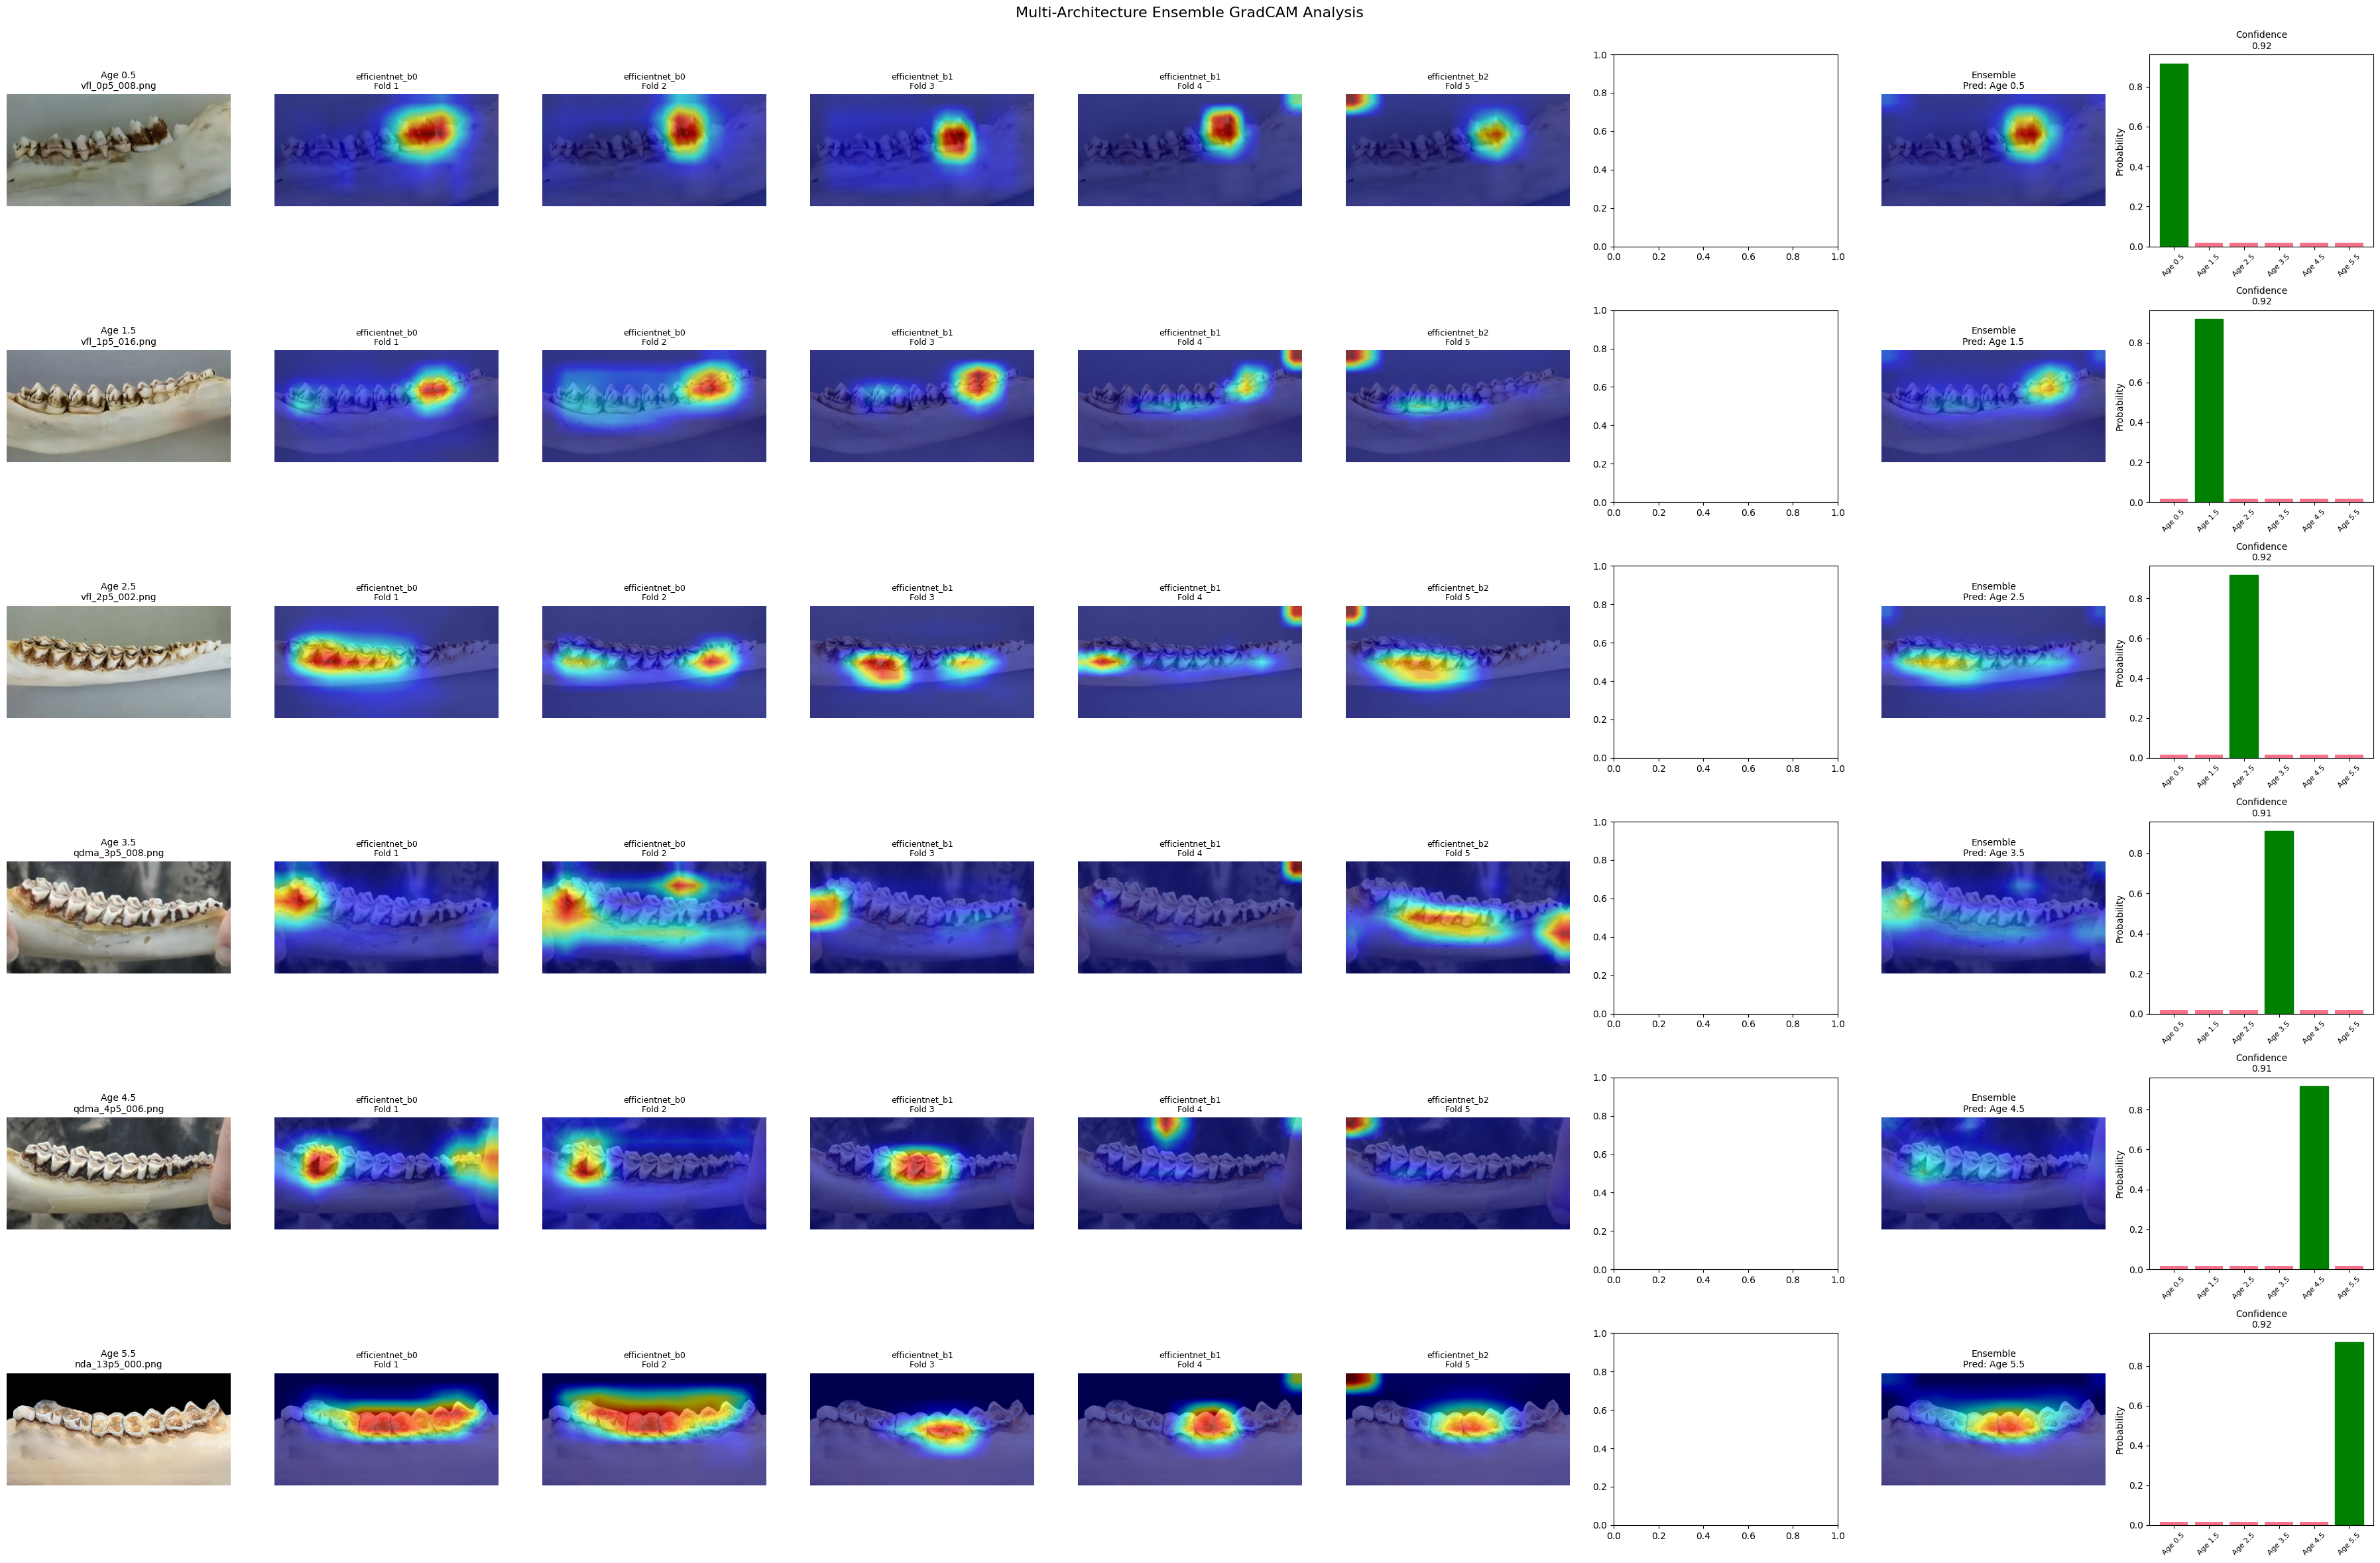

Multi-architecture GradCAM analysis saved to 'multi_arch_gradcam/multi_arch_analysis.png'
Creating simplified age group comparison...
Selecting representative images using 'random' method:
  Age 0.5: vfl_0p5_008.png (index 189) - RANDOM
  Age 1.5: vfl_1p5_016.png (index 204) - RANDOM
  Age 2.5: vfl_2p5_002.png (index 215) - RANDOM
  Age 3.5: qdma_3p5_008.png (index 126) - RANDOM
  Age 4.5: qdma_4p5_006.png (index 145) - RANDOM
  Age 5.5: nda_13p5_000.png (index 40) - RANDOM

Debugging model structure for efficientnet_b0:
  conv_stem: <class 'torch.nn.modules.conv.Conv2d'>
  bn1: <class 'timm.layers.norm_act.BatchNormAct2d'>
  blocks: <class 'torch.nn.modules.container.Sequential'>
  conv_head: <class 'torch.nn.modules.conv.Conv2d'>
  bn2: <class 'timm.layers.norm_act.BatchNormAct2d'>
  global_pool: <class 'timm.layers.adaptive_avgmax_pool.SelectAdaptivePool2d'>
  classifier: <class 'torch.nn.modules.container.Sequential'>
  blocks length: 7
  last block type: <class 'torch.nn.modules.c

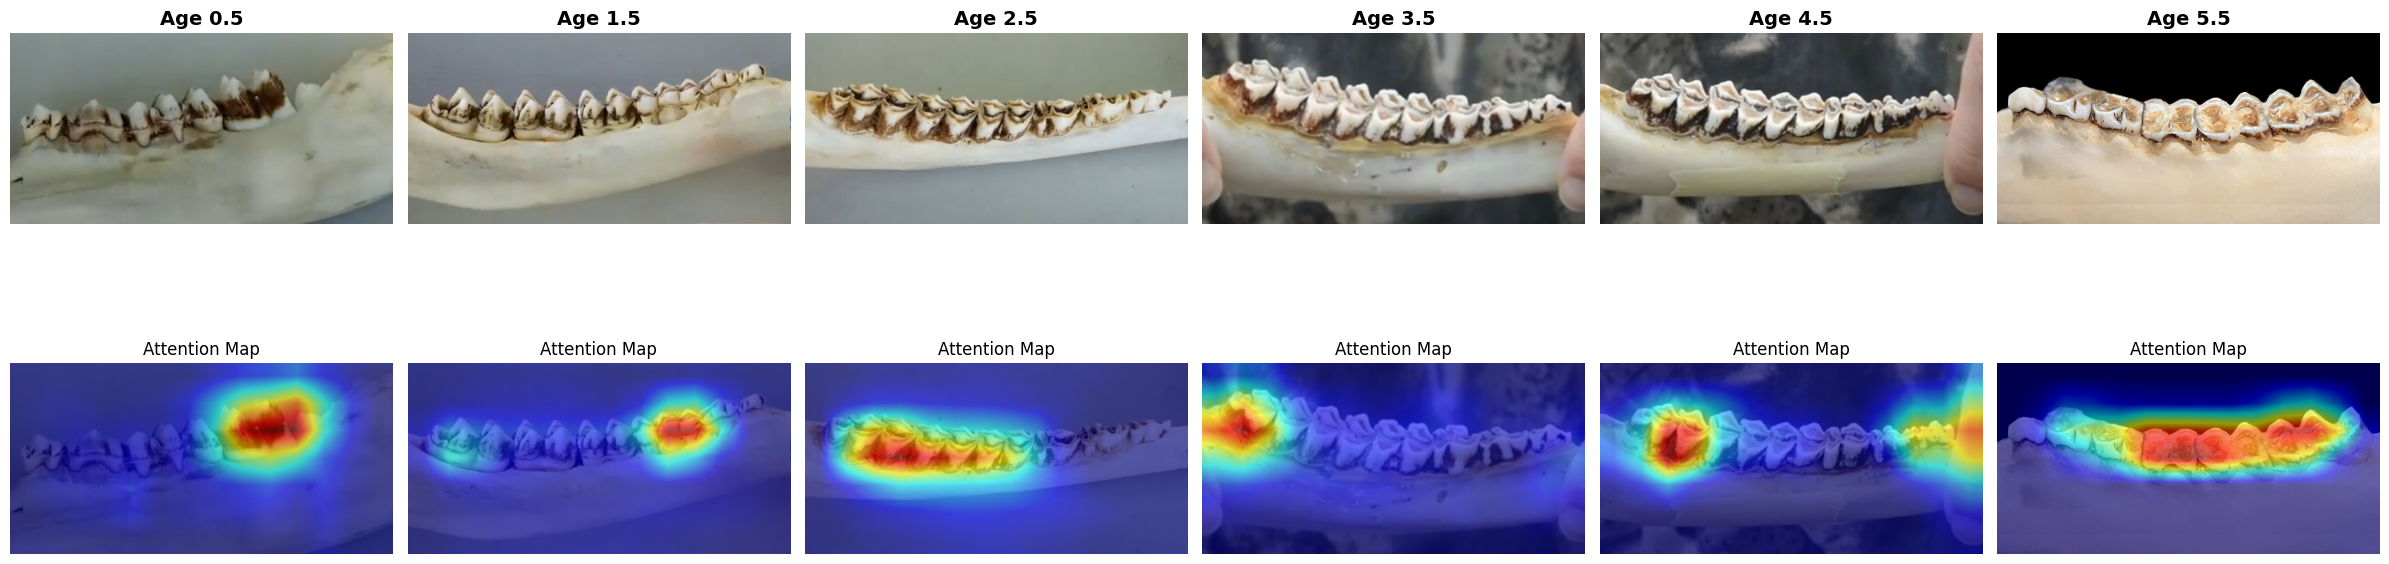

Simplified comparison saved to 'multi_arch_gradcam/simplified_age_comparison.png'

Multi-Architecture GradCAM Analysis Complete!
Generated files:
- multi_arch_gradcam/multi_arch_analysis.png: Comprehensive analysis
- multi_arch_gradcam/simplified_age_comparison.png: Simplified comparison


In [6]:
# Multi-Architecture Ensemble GradCAM Analysis Script
# Shows attention maps for one representative image from each age group

import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import os
import glob
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")

# Configuration to match training script
IMAGE_SIZE = (224, 448)  # height, width

def load_original_data():
    """Load and process the original deer tooth images - EXACT same as training script"""
    try:
        fpath = "G:\\Dropbox\\AI Projects\\buck\\tooth_analysis\\images\\*.png"
        
        image_paths = glob.glob(fpath)
        if not image_paths:
            raise FileNotFoundError(f"No images found at {fpath}")
        
        images = []
        ages = []
        filenames = []
        
        print(f"Processing {len(image_paths)} image files...")
        
        for img_path in image_paths:
            try:
                img = cv2.imread(img_path)
                if img is None:
                    continue
                
                # Convert BGR to RGB for correct color display
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img_resized = cv2.resize(img, IMAGE_SIZE[::-1])  # OpenCV uses (width, height)
                
                filename = os.path.basename(img_path)
                filename_no_ext = os.path.splitext(filename)[0]
                parts = filename_no_ext.split('_')
                
                if len(parts) < 3:
                    continue
                
                bbb_part = parts[1]
                
                if 'p' not in bbb_part:
                    continue
                
                value_str = bbb_part.replace('p', '.')
                try:
                    age_value = float(value_str)
                except ValueError:
                    continue
                
                images.append(img_resized)
                ages.append(age_value)
                filenames.append(filename)
                
            except Exception as e:
                continue
        
        if not images:
            raise ValueError("No valid images loaded")
        
        # Group ages: anything >= 5.5 becomes 5.5 (EXACT same as training)
        ages_grouped = [5.5 if age >= 5.5 else age for age in ages]
        
        # Filter out classes with too few samples (EXACT same as training)
        age_counts = Counter(ages_grouped)
        print(f"Age distribution: {dict(age_counts)}")
        
        valid_ages = {age for age, count in age_counts.items() if count >= 3}  # Same as training
        
        filtered_images = []
        filtered_ages = []
        filtered_filenames = []
        
        for img, age, filename in zip(images, ages_grouped, filenames):
            if age in valid_ages:
                filtered_images.append(img)
                filtered_ages.append(age)
                filtered_filenames.append(filename)
        
        print(f"Available age groups: {sorted(list(valid_ages))}")
        
        return np.array(filtered_images), filtered_ages, filtered_filenames
        
    except Exception as e:
        print(f"Error loading data: {e}")
        raise

def find_latest_ensemble_directory():
    """Find the most recent multi-architecture ensemble directory"""
    patterns = ["multi_arch_ensemble_*"]
    
    dirs = []
    for pattern in patterns:
        dirs.extend(glob.glob(pattern))
    
    if not dirs:
        raise FileNotFoundError("No multi-architecture ensemble directories found! Please run the training script first.")
    
    latest_dir = max(dirs, key=os.path.getmtime)
    print(f"Found ensemble directory: {latest_dir}")
    return latest_dir

def load_trained_ensemble(ensemble_dir):
    """Load the trained multi-architecture ensemble models"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load metadata
    metadata_path = os.path.join(ensemble_dir, "metadata.json")
    if not os.path.exists(metadata_path):
        raise FileNotFoundError(f"No metadata.json found in {ensemble_dir}")
    
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)
    
    label_mapping = metadata['label_mapping']
    num_classes = len(label_mapping)
    architectures_used = metadata.get('architectures_used', [])
    cv_scores = metadata['cv_scores']
    
    print(f"Architectures used: {architectures_used}")
    
    # Load individual models
    models = []
    model_architectures = []
    
    # Find all model files
    model_files = glob.glob(os.path.join(ensemble_dir, "*_fold_*_*.pth"))
    model_files = [f for f in model_files if 'ensemble' not in os.path.basename(f)]
    model_files = sorted(model_files)
    
    print(f"Found {len(model_files)} model files")
    
    for model_file in model_files:
        try:
            checkpoint = torch.load(model_file, map_location=device)
            
            architecture = checkpoint.get('model_architecture', 'unknown')
            fold_num = checkpoint.get('fold', 0)
            cv_score = checkpoint.get('cv_score', 0.0)
            
            # Create model with the correct architecture
            model = create_model(architecture, num_classes)
            
            # Load trained weights
            model.load_state_dict(checkpoint['model_state_dict'])
            model = model.to(device)
            model.eval()
            
            models.append(model)
            model_architectures.append(architecture)
            
            print(f"Loaded fold {fold_num} model ({architecture}): {cv_score:.1f}% CV accuracy")
            
        except Exception as e:
            print(f"Failed to load {model_file}: {e}")
            continue
    
    if not models:
        raise ValueError("No models could be loaded!")
    
    return models, model_architectures, label_mapping, cv_scores

def create_model(architecture, num_classes):
    """Create a model with the specified architecture"""
    model = timm.create_model(architecture, pretrained=False, num_classes=num_classes)
    
    # Apply same modifications as training script
    if 'resnet' in architecture:
        frozen_layers = ['conv1', 'bn1', 'layer1', 'layer2', 'layer3']
        for name, param in model.named_parameters():
            for frozen_layer in frozen_layers:
                if name.startswith(frozen_layer):
                    param.requires_grad = False
                    break
    elif 'efficientnet' in architecture:
        for name, param in model.named_parameters():
            if 'blocks.0' in name or 'blocks.1' in name or 'blocks.2' in name:
                param.requires_grad = False
    elif 'mobilenet' in architecture:
        for name, param in model.named_parameters():
            if 'features.0' in name or 'features.1' in name or 'features.2' in name:
                param.requires_grad = False
    
    # Modify classifier layer
    if hasattr(model, 'fc'):
        in_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features, num_classes)
        )
    elif hasattr(model, 'classifier'):
        if hasattr(model.classifier, 'in_features'):
            in_features = model.classifier.in_features
            model.classifier = nn.Sequential(
                nn.Dropout(0.3),
                nn.Linear(in_features, num_classes)
            )
        else:
            in_features = model.classifier[-1].in_features
            model.classifier[-1] = nn.Sequential(
                nn.Dropout(0.3),
                nn.Linear(in_features, num_classes)
            )
    
    return model

class GradCAM:
    """GradCAM implementation for multiple architectures"""
    
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.handles = []
        
        handle1 = self.target_layer.register_forward_hook(self.forward_hook)
        handle2 = self.target_layer.register_backward_hook(self.backward_hook)
        self.handles.extend([handle1, handle2])
    
    def forward_hook(self, module, input, output):
        self.activations = output.detach()
    
    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
    
    def remove_hooks(self):
        for handle in self.handles:
            handle.remove()
        self.handles = []
    
    def generate_cam(self, input_image, class_idx):
        self.model.eval()
        
        device = next(self.model.parameters()).device
        input_image = input_image.to(device)
        
        input_image.requires_grad_()
        output = self.model(input_image)
        
        self.model.zero_grad()
        
        class_score = output[:, class_idx]
        class_score.backward()
        
        if self.gradients is None or self.activations is None:
            return np.zeros(IMAGE_SIZE)
        
        gradients = self.gradients[0].to(device)
        activations = self.activations[0].to(device)
        
        weights = torch.mean(gradients, dim=(1, 2))
        
        cam = torch.zeros(activations.shape[1:], dtype=torch.float32, device=device)
        for i, w in enumerate(weights):
            cam += w * activations[i]
        
        cam = F.relu(cam)
        
        if cam.max() > 0:
            cam = cam / cam.max()
        
        return cam.detach().cpu().numpy()

def get_target_layer(model, architecture):
    """Get the appropriate target layer for GradCAM based on architecture"""
    if 'resnet' in architecture:
        return model.layer4[-1].conv2
    elif 'efficientnet' in architecture:
        # EfficientNet structure: conv_stem -> blocks -> conv_head -> classifier
        if hasattr(model, 'conv_head'):
            print(f"  Using conv_head for {architecture}")
            return model.conv_head
        elif hasattr(model, 'blocks') and len(model.blocks) > 0:
            # Use the last block - try to find the last conv layer in it
            last_block = model.blocks[-1]
            print(f"  Using last block for {architecture}: {type(last_block)}")
            
            # Look for conv layers in the last block
            for name, module in reversed(list(last_block.named_children())):
                if isinstance(module, nn.Conv2d):
                    print(f"    Found conv layer in last block: {name}")
                    return module
            
            # If no conv layer found, return the whole block
            return last_block
        else:
            # Fallback: find the last conv layer in the entire model
            conv_layers = find_conv_layers(model, architecture)
            if conv_layers:
                target_name, target_layer = conv_layers[-1]
                print(f"  Using fallback last conv layer: {target_name}")
                return target_layer
            else:
                raise ValueError(f"Cannot find any convolutional layers in EfficientNet: {architecture}")
    elif 'mobilenet' in architecture:
        if hasattr(model, 'features'):
            return model.features[-1]
        elif hasattr(model, 'blocks'):
            return model.blocks[-1]
        else:
            # Fallback: find the last conv layer
            conv_layers = find_conv_layers(model, architecture)
            if conv_layers:
                target_name, target_layer = conv_layers[-1]
                print(f"  Using fallback last conv layer: {target_name}")
                return target_layer
            else:
                raise ValueError(f"Cannot find suitable target layer for MobileNet: {architecture}")
    else:
        # Default fallback - try to find a suitable layer
        if hasattr(model, 'features'):
            return model.features[-1]
        elif hasattr(model, 'layer4'):
            return model.layer4[-1]
        elif hasattr(model, 'blocks'):
            return model.blocks[-1]
        elif hasattr(model, 'conv_head'):
            return model.conv_head
        else:
            # Last resort: find any conv layer
            conv_layers = find_conv_layers(model, architecture)
            if conv_layers:
                target_name, target_layer = conv_layers[-1]
                print(f"  Using fallback last conv layer: {target_name}")
                return target_layer
            else:
                raise ValueError(f"Cannot determine target layer for architecture: {architecture}")

def debug_model_structure(model, architecture):
    """Debug function to print model structure"""
    print(f"\nDebugging model structure for {architecture}:")
    for name, module in model.named_children():
        print(f"  {name}: {type(module)}")
    
    # For EfficientNet, also check blocks structure
    if 'efficientnet' in architecture and hasattr(model, 'blocks'):
        print(f"  blocks length: {len(model.blocks)}")
        if len(model.blocks) > 0:
            print(f"  last block type: {type(model.blocks[-1])}")
            for name, module in model.blocks[-1].named_children():
                print(f"    last block.{name}: {type(module)}")
    
    return model

def find_conv_layers(model, architecture):
    """Find all convolutional layers in the model"""
    conv_layers = []
    
    def find_conv_recursive(module, prefix=""):
        for name, child in module.named_children():
            full_name = f"{prefix}.{name}" if prefix else name
            if isinstance(child, (nn.Conv2d, nn.Conv1d)):
                conv_layers.append((full_name, child))
            else:
                find_conv_recursive(child, full_name)
    
    find_conv_recursive(model)
    print(f"\nFound {len(conv_layers)} conv layers in {architecture}:")
    for name, layer in conv_layers[-5:]:  # Show last 5
        print(f"  {name}: {layer}")
    
    return conv_layers

class MultiArchGradCAMAnalyzer:
    """Analyzer for multi-architecture ensemble GradCAM visualization"""
    
    def __init__(self, ensemble_dir=None):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        print("Multi-Architecture Ensemble GradCAM Analyzer")
        print("=" * 50)
        print(f"Device: {self.device}")
        
        # Find ensemble directory if not provided
        if ensemble_dir is None:
            ensemble_dir = find_latest_ensemble_directory()
        
        self.ensemble_dir = ensemble_dir
        
        # Load data and models
        self.load_data_and_models()
        
        # Create output directory
        Path("multi_arch_gradcam").mkdir(exist_ok=True)
        
        print("Ready for multi-architecture GradCAM analysis")
    
    def load_data_and_models(self):
        """Load original data and trained models"""
        print("Loading original data...")
        self.images, self.ages, self.filenames = load_original_data()
        
        print("Loading trained ensemble...")
        self.models, self.model_architectures, self.label_mapping, self.cv_scores = load_trained_ensemble(self.ensemble_dir)
        
        # Create reverse mapping for age indices
        self.age_to_idx = {}
        self.idx_to_age = {}
        
        for age_str, idx in self.label_mapping.items():
            age_float = float(age_str)
            self.age_to_idx[age_float] = idx
            self.idx_to_age[idx] = age_float
        
        self.unique_ages = sorted(list(self.age_to_idx.keys()))
        self.num_classes = len(self.unique_ages)
        
        print(f"Loaded {len(self.models)} models")
        print(f"Model architectures: {self.model_architectures}")
        print(f"Available age groups: {self.unique_ages}")
    
    def preprocess_image(self, image):
        """Preprocess image for model input - EXACT same as training"""
        if isinstance(image, np.ndarray):
            image = torch.FloatTensor(image)
        
        if image.max() > 1.0:
            image = image / 255.0
        
        if len(image.shape) == 3 and image.shape[-1] == 3:
            image = image.permute(2, 0, 1)
        
        if image.shape[-2:] != IMAGE_SIZE:
            image = F.interpolate(image.unsqueeze(0), size=IMAGE_SIZE, 
                                mode='bilinear', align_corners=False).squeeze(0)
        
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        image = (image - mean) / std
        
        return image.unsqueeze(0).to(self.device)
    
    def overlay_heatmap(self, image, heatmap, alpha=0.6):
        """Overlay heatmap on original image"""
        heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
        
        heatmap_colored = cv2.applyColorMap(
            (heatmap_resized * 255).astype(np.uint8), 
            cv2.COLORMAP_JET
        )
        heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
        heatmap_colored = heatmap_colored.astype(np.float32) / 255.0
        
        if image.max() <= 1.0:
            image_display = image
        else:
            image_display = image.astype(np.float32) / 255.0
        
        overlaid = alpha * heatmap_colored + (1 - alpha) * image_display
        return overlaid
    
    def select_representative_images(self, selection_method='first', specific_images=None, random_seed=42):
        """
        Select representative images from each age group
        
        Args:
            selection_method: 'first', 'random', 'last', 'middle', or 'specific'
            specific_images: dict of {age: filename} for 'specific' method
            random_seed: seed for random selection
        """
        selected_samples = {}
        
        # Group images by age
        age_groups = {}
        for i, age in enumerate(self.ages):
            if age not in age_groups:
                age_groups[age] = []
            age_groups[age].append(i)
        
        print(f"Selecting representative images using '{selection_method}' method:")
        
        if selection_method == 'specific' and specific_images:
            # Use user-specified images
            for age, target_filename in specific_images.items():
                if age in age_groups:
                    # Find the image with the specified filename
                    found = False
                    for idx in age_groups[age]:
                        if self.filenames[idx] == target_filename:
                            selected_samples[age] = {
                                'index': idx,
                                'filename': self.filenames[idx],
                                'image': self.images[idx],
                                'age': self.ages[idx]
                            }
                            print(f"  Age {age}: {target_filename} (index {idx}) - SPECIFIED")
                            found = True
                            break
                    
                    if not found:
                        print(f"  Age {age}: {target_filename} NOT FOUND, using first available")
                        idx = age_groups[age][0]
                        selected_samples[age] = {
                            'index': idx,
                            'filename': self.filenames[idx],
                            'image': self.images[idx],
                            'age': self.ages[idx]
                        }
                        print(f"  Age {age}: {self.filenames[idx]} (index {idx}) - FALLBACK")
                else:
                    print(f"  Age {age}: No images available for this age group")
        else:
            # Automatic selection methods
            if selection_method == 'random':
                np.random.seed(random_seed)
            
            for age in self.unique_ages:
                if age in age_groups:
                    indices = age_groups[age]
                    
                    if selection_method == 'first':
                        idx = indices[0]
                    elif selection_method == 'last':
                        idx = indices[-1]
                    elif selection_method == 'middle':
                        idx = indices[len(indices) // 2]
                    elif selection_method == 'random':
                        idx = np.random.choice(indices)
                    else:
                        # Default to first
                        idx = indices[0]
                    
                    selected_samples[age] = {
                        'index': idx,
                        'filename': self.filenames[idx],
                        'image': self.images[idx],
                        'age': self.ages[idx]
                    }
                    print(f"  Age {age}: {self.filenames[idx]} (index {idx}) - {selection_method.upper()}")
                else:
                    print(f"  Age {age}: No images available")
        
        return selected_samples
    
    def list_available_images(self):
        """List all available images by age group"""
        age_groups = {}
        for i, age in enumerate(self.ages):
            if age not in age_groups:
                age_groups[age] = []
            age_groups[age].append(i)
        
        print("\nAvailable images by age group:")
        print("=" * 50)
        for age in self.unique_ages:
            if age in age_groups:
                print(f"\nAge {age} ({len(age_groups[age])} images):")
                for idx in age_groups[age]:
                    print(f"  {idx:3d}: {self.filenames[idx]}")
            else:
                print(f"\nAge {age}: No images available")
        
        return age_groups
    
    def get_ensemble_prediction(self, input_tensor):
        """Get ensemble prediction for an image"""
        # Use CV scores as weights (same as training script)
        scores_array = np.array(self.cv_scores)
        weights = np.exp(scores_array / 20)
        weights = weights / weights.sum()
        
        ensemble_probs = np.zeros(self.num_classes)
        
        for i, model in enumerate(self.models):
            with torch.no_grad():
                outputs = model(input_tensor)
                probs = F.softmax(outputs, dim=1).cpu().numpy()[0]
                ensemble_probs += weights[i] * probs
        
        predicted_class = np.argmax(ensemble_probs)
        confidence = ensemble_probs[predicted_class]
        
        return predicted_class, confidence, ensemble_probs
    
    def create_multi_arch_visualization(self, selection_method='first', specific_images=None, random_seed=42):
        """Create comprehensive multi-architecture GradCAM visualization"""
        print("Creating multi-architecture GradCAM visualization...")
        
        selected_samples = self.select_representative_images(selection_method, specific_images, random_seed)
        
        if not selected_samples:
            print("No representative images found!")
            return
        
        # Sort by age for consistent display
        sorted_ages = sorted(selected_samples.keys())
        num_ages = len(sorted_ages)
        
        # Create figure: ages x (original + models + ensemble + prediction)
        num_cols = 2 + len(self.models) + 2  # original + models + ensemble + prediction bars
        fig, axes = plt.subplots(num_ages, num_cols, figsize=(4*num_cols, 4*num_ages))
        
        if num_ages == 1:
            axes = axes.reshape(1, -1)
        
        # Initialize GradCAM for each model
        grad_cams = []
        for i, (model, arch) in enumerate(zip(self.models, self.model_architectures)):
            try:
                # Debug model structure first
                debug_model_structure(model, arch)
                find_conv_layers(model, arch)
                
                target_layer = get_target_layer(model, arch)
                grad_cam = GradCAM(model, target_layer)
                grad_cams.append(grad_cam)
                print(f"Successfully setup GradCAM for model {i+1} ({arch})")
            except Exception as e:
                print(f"Failed to setup GradCAM for model {i+1} ({arch}): {e}")
                import traceback
                traceback.print_exc()
                grad_cams.append(None)
        
        try:
            for age_idx, age in enumerate(sorted_ages):
                sample = selected_samples[age]
                original_image = sample['image']
                true_age = sample['age']
                filename = sample['filename']
                
                # Preprocess for model
                input_tensor = self.preprocess_image(original_image.copy())
                
                # Get ensemble prediction
                pred_class, confidence, all_probs = self.get_ensemble_prediction(input_tensor)
                predicted_age = self.idx_to_age[pred_class]
                
                # Display original image
                if original_image.max() > 1.0:
                    display_image = original_image.astype(np.float32) / 255.0
                else:
                    display_image = original_image.astype(np.float32)
                
                axes[age_idx, 0].imshow(display_image)
                axes[age_idx, 0].set_title(f'Age {true_age}\n{filename}', fontsize=10)
                axes[age_idx, 0].axis('off')
                
                # Generate GradCAM for each model
                model_heatmaps = []
                
                for model_idx, (model, grad_cam, arch) in enumerate(zip(self.models, grad_cams, self.model_architectures)):
                    if grad_cam is None:
                        axes[age_idx, model_idx + 1].text(0.5, 0.5, 'Failed', 
                                                         transform=axes[age_idx, model_idx + 1].transAxes,
                                                         ha='center', va='center')
                        axes[age_idx, model_idx + 1].axis('off')
                        model_heatmaps.append(None)
                        continue
                    
                    try:
                        # Generate heatmap using true class for consistency
                        true_class_idx = self.age_to_idx[true_age]
                        heatmap = grad_cam.generate_cam(input_tensor.clone(), true_class_idx)
                        model_heatmaps.append(heatmap)
                        
                        # Create overlay
                        overlaid = self.overlay_heatmap(display_image, heatmap)
                        
                        # Display
                        axes[age_idx, model_idx + 1].imshow(overlaid)
                        axes[age_idx, model_idx + 1].set_title(f'{arch}\nFold {model_idx + 1}', fontsize=9)
                        axes[age_idx, model_idx + 1].axis('off')
                        
                    except Exception as e:
                        print(f"Error processing model {model_idx + 1} ({arch}) for age {age}: {e}")
                        axes[age_idx, model_idx + 1].text(0.5, 0.5, 'Error', 
                                                         transform=axes[age_idx, model_idx + 1].transAxes,
                                                         ha='center', va='center')
                        axes[age_idx, model_idx + 1].axis('off')
                        model_heatmaps.append(None)
                
                # Create ensemble heatmap (average of valid heatmaps)
                valid_heatmaps = [h for h in model_heatmaps if h is not None]
                if valid_heatmaps:
                    ensemble_heatmap = np.mean(valid_heatmaps, axis=0)
                    ensemble_overlaid = self.overlay_heatmap(display_image, ensemble_heatmap)
                    
                    axes[age_idx, -2].imshow(ensemble_overlaid)
                    axes[age_idx, -2].set_title(f'Ensemble\nPred: Age {predicted_age}', fontsize=10)
                    axes[age_idx, -2].axis('off')
                else:
                    axes[age_idx, -2].text(0.5, 0.5, 'No Valid\nHeatmaps', 
                                          transform=axes[age_idx, -2].transAxes,
                                          ha='center', va='center')
                    axes[age_idx, -2].axis('off')
                
                # Show prediction probabilities
                class_names = [f'Age {age}' for age in self.unique_ages]
                bars = axes[age_idx, -1].bar(range(len(class_names)), all_probs)
                axes[age_idx, -1].set_xticks(range(len(class_names)))
                axes[age_idx, -1].set_xticklabels(class_names, rotation=45, fontsize=8)
                axes[age_idx, -1].set_ylabel('Probability')
                axes[age_idx, -1].set_title(f'Confidence\n{confidence:.2f}', fontsize=10)
                
                # Color the bars: red for predicted, green for true
                bars[pred_class].set_color('red')
                true_class_idx = self.age_to_idx[true_age]
                bars[true_class_idx].set_color('green')
                
                # Clear GPU memory
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
        
        finally:
            # Clean up all GradCAMs
            for grad_cam in grad_cams:
                if grad_cam is not None:
                    grad_cam.remove_hooks()
        
        # Add overall title
        fig.suptitle('Multi-Architecture Ensemble GradCAM Analysis', fontsize=16, y=0.98)
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.95)
        plt.savefig('multi_arch_gradcam/multi_arch_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("Multi-architecture GradCAM analysis saved to 'multi_arch_gradcam/multi_arch_analysis.png'")
    
    def create_simplified_comparison(self, selection_method='first', specific_images=None, random_seed=42):
        """Create a simplified side-by-side comparison of all age groups"""
        print("Creating simplified age group comparison...")
        
        selected_samples = self.select_representative_images(selection_method, specific_images, random_seed)
        
        if not selected_samples:
            print("No representative images found!")
            return
        
        sorted_ages = sorted(selected_samples.keys())
        num_ages = len(sorted_ages)
        
        # Create simple 2-row visualization: original images and ensemble attention
        fig, axes = plt.subplots(2, num_ages, figsize=(4*num_ages, 8))
        
        if num_ages == 1:
            axes = axes.reshape(2, 1)
        
        # Initialize GradCAM for ensemble (use first model as representative)
        grad_cam = None
        if self.models:
            try:
                debug_model_structure(self.models[0], self.model_architectures[0])
                find_conv_layers(self.models[0], self.model_architectures[0])
                
                target_layer = get_target_layer(self.models[0], self.model_architectures[0])
                grad_cam = GradCAM(self.models[0], target_layer)
                print(f"Setup GradCAM for simplified view using {self.model_architectures[0]}")
            except Exception as e:
                print(f"Failed to setup GradCAM: {e}")
                import traceback
                traceback.print_exc()
        
        try:
            for age_idx, age in enumerate(sorted_ages):
                sample = selected_samples[age]
                original_image = sample['image']
                filename = sample['filename']
                
                # Display original image
                if original_image.max() > 1.0:
                    display_image = original_image.astype(np.float32) / 255.0
                else:
                    display_image = original_image.astype(np.float32)
                
                axes[0, age_idx].imshow(display_image)
                axes[0, age_idx].set_title(f'Age {age}', fontsize=14, fontweight='bold')
                axes[0, age_idx].axis('off')
                
                # Generate and display attention map
                if grad_cam is not None:
                    try:
                        input_tensor = self.preprocess_image(original_image.copy())
                        true_class_idx = self.age_to_idx[age]
                        heatmap = grad_cam.generate_cam(input_tensor.clone(), true_class_idx)
                        overlaid = self.overlay_heatmap(display_image, heatmap)
                        
                        axes[1, age_idx].imshow(overlaid)
                        axes[1, age_idx].set_title('Attention Map', fontsize=12)
                        axes[1, age_idx].axis('off')
                        
                    except Exception as e:
                        print(f"Error generating attention for age {age}: {e}")
                        axes[1, age_idx].text(0.5, 0.5, 'Error', 
                                             transform=axes[1, age_idx].transAxes,
                                             ha='center', va='center')
                        axes[1, age_idx].axis('off')
                else:
                    axes[1, age_idx].text(0.5, 0.5, 'No GradCAM', 
                                         transform=axes[1, age_idx].transAxes,
                                         ha='center', va='center')
                    axes[1, age_idx].axis('off')
        
        finally:
            if grad_cam is not None:
                grad_cam.remove_hooks()
        
        # Add row labels
        axes[0, 0].set_ylabel('Original Images', fontsize=14, fontweight='bold')
        axes[1, 0].set_ylabel('Attention Maps', fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.savefig('multi_arch_gradcam/simplified_age_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("Simplified comparison saved to 'multi_arch_gradcam/simplified_age_comparison.png'")
    
    def run_complete_analysis(self, selection_method='first', specific_images=None, random_seed=42, list_images=False):
        """Run complete multi-architecture GradCAM analysis"""
        print("\nStarting Multi-Architecture GradCAM Analysis")
        print("=" * 50)
        
        if list_images:
            self.list_available_images()
            print("\nTo use specific images, call:")
            print("analyzer.run_complete_analysis(selection_method='specific', specific_images={")
            print("    0.5: 'your_chosen_filename.png',")
            print("    1.5: 'your_chosen_filename.png',")
            print("    # ... etc")
            print("})")
            return
        
        try:
            # Create comprehensive visualization
            self.create_multi_arch_visualization(selection_method, specific_images, random_seed)
            
            # Create simplified comparison
            self.create_simplified_comparison(selection_method, specific_images, random_seed)
            
            print("\nMulti-Architecture GradCAM Analysis Complete!")
            print("Generated files:")
            print("- multi_arch_gradcam/multi_arch_analysis.png: Comprehensive analysis")
            print("- multi_arch_gradcam/simplified_age_comparison.png: Simplified comparison")
            
        except Exception as e:
            print(f"Error in analysis: {e}")
            import traceback
            traceback.print_exc()

def main():
    """Main function to run multi-architecture GradCAM analysis"""
    print("Multi-Architecture Ensemble GradCAM Analysis")
    print("=" * 60)
    
    try:
        # Initialize analyzer
        analyzer = MultiArchGradCAMAnalyzer()
        
        # OPTION 1: Random selection - one random image from each age group
        analyzer.run_complete_analysis(selection_method='random', random_seed=42)
        
        # OPTION 2: Default - use first image from each age group
        # analyzer.run_complete_analysis()
        
        # OPTION 3: List all available images first
        # analyzer.run_complete_analysis(list_images=True)
        
        # OPTION 4: Use last image from each group
        # analyzer.run_complete_analysis(selection_method='last')
        
        # OPTION 5: Use middle image from each group
        # analyzer.run_complete_analysis(selection_method='middle')
        
        # OPTION 6: Use specific images (uncomment and modify)
        # specific_images = {
        #     0.5: 'bsd_0p5_001.png',  # Replace with your chosen filenames
        #     1.5: 'cpj_1p5_002.png',
        #     2.5: 'bsd_2p5_001.png',
        #     3.5: 'bsd_3p5_002.png',
        #     4.5: 'cpj_4p5_001.png',
        #     5.5: 'cpj_7p5_001.png',
        # }
        # analyzer.run_complete_analysis(selection_method='specific', specific_images=specific_images)
        
    except Exception as e:
        print(f"Analysis failed: {e}")
        import traceback
        traceback.print_exc()

# Alternative usage examples for interactive use:
def example_usage():
    """Example of how to use different selection methods"""
    
    # Initialize
    analyzer = MultiArchGradCAMAnalyzer()
    
    # 1. List all available images
    print("=== LISTING ALL AVAILABLE IMAGES ===")
    analyzer.list_available_images()
    
    # 2. Use random selection
    print("\n=== USING RANDOM SELECTION ===")
    analyzer.run_complete_analysis(selection_method='random', random_seed=456)
    
    # 3. Use specific images
    print("\n=== USING SPECIFIC IMAGES ===")
    my_chosen_images = {
        0.5: 'bsd_0p5_001.png',  # Change these to your preferred images
        1.5: 'cpj_1p5_003.png',
        2.5: 'bsd_2p5_002.png',
        3.5: 'bsd_3p5_001.png',
        4.5: 'cpj_4p5_002.png',
        5.5: 'cpj_6p5_001.png',
    }
    analyzer.run_complete_analysis(selection_method='specific', specific_images=my_chosen_images)

if __name__ == "__main__":
    main()
    
    # To use the examples instead:
    # example_usage()

In [ ]:
# "improved" resume script
# Resume Training Script - Continue from where training stopped

import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import timm
import numpy as np
import cv2
import random
import json
import os
import glob
import pickle
from datetime import datetime
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# CONFIGURATION - Should match your original training
AVAILABLE_ARCHITECTURES = ['resnet18', 'resnet34', 'resnet50', 'efficientnet_b0', 'mobilenetv3_large_100']
AUGMENTATION_TARGET = 1200
NUM_FOLDS = 5
IMAGE_SIZE = (224, 448)
BATCH_SIZE_TRAIN = 64
BATCH_SIZE_TEST = 96
NUM_WORKERS = 4

plt.style.use('default')
sns.set_palette("husl")

try:
    from torch.cuda.amp import autocast, GradScaler
    MIXED_PRECISION_AVAILABLE = True
except ImportError:
    MIXED_PRECISION_AVAILABLE = False
    class autocast:
        def __enter__(self):
            return self
        def __exit__(self, *args):
            pass

def load_original_data():
    try:
        fpath = "G:\\Dropbox\\AI Projects\\buck\\tooth_analysis\\images\\*.png"
        
        image_paths = glob.glob(fpath)
        if not image_paths:
            raise FileNotFoundError(f"No images found at {fpath}")
        
        images = []
        ages = []
        
        for img_path in image_paths:
            try:
                img = cv2.imread(img_path)
                if img is None:
                    continue
                
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img_resized = cv2.resize(img, IMAGE_SIZE[::-1])
                
                filename = os.path.basename(img_path)
                filename_no_ext = os.path.splitext(filename)[0]
                parts = filename_no_ext.split('_')
                
                if len(parts) < 3:
                    continue
                
                bbb_part = parts[1]
                
                if 'p' not in bbb_part:
                    continue
                
                value_str = bbb_part.replace('p', '.')
                try:
                    age_value = float(value_str)
                except ValueError:
                    continue
                
                images.append(img_resized)
                ages.append(age_value)
                
            except Exception as e:
                continue
        
        if not images:
            raise ValueError("No valid images loaded")
        
        ages_grouped = [5.5 if age >= 5.5 else age for age in ages]
        
        age_counts = Counter(ages_grouped)
        valid_ages = {age for age, count in age_counts.items() if count >= 3}
        
        filtered_images = []
        filtered_ages = []
        
        for img, age in zip(images, ages_grouped):
            if age in valid_ages:
                filtered_images.append(img)
                filtered_ages.append(age)
        
        return np.array(filtered_images), filtered_ages
        
    except Exception as e:
        print(f"Error loading data: {e}")
        raise

def enhanced_augment_image(image):
    if image.dtype != np.uint8:
        image = image.astype(np.uint8)
    
    if random.random() < 0.7:
        angle = random.uniform(-15, 15)
        h, w = image.shape[:2]
        M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1.0)
        image = cv2.warpAffine(image, M, (w, h))
    
    if random.random() < 0.5:
        image = cv2.flip(image, 1)
    
    if random.random() < 0.8:
        alpha = random.uniform(0.7, 1.3)
        beta = random.randint(-25, 25)
        image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    
    if random.random() < 0.4:
        gamma = random.uniform(0.8, 1.2)
        inv_gamma = 1.0 / gamma
        table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
        image = cv2.LUT(image, table)
    
    if random.random() < 0.3:
        noise = np.random.normal(0, 7, image.shape).astype(np.int16)
        image_int16 = image.astype(np.int16)
        noisy_image = np.clip(image_int16 + noise, 0, 255)
        image = noisy_image.astype(np.uint8)
    
    return image

def create_augmented_data(X_train, y_train):
    class_counts = Counter(y_train)
    max_count = max(class_counts.values())
    target_count = max(AUGMENTATION_TARGET, max_count)
    
    X_aug = []
    y_aug = []
    
    for class_idx in range(len(set(y_train))):
        class_mask = y_train == class_idx
        class_images = X_train[class_mask]
        current_count = len(class_images)
        
        if current_count == 0:
            continue
        
        for _ in range(4):
            X_aug.extend(class_images)
            y_aug.extend([class_idx] * current_count)
        
        needed = target_count - (current_count * 4)
        for i in range(needed):
            orig_idx = random.randint(0, current_count - 1)
            aug_img = enhanced_augment_image(class_images[orig_idx].copy())
            X_aug.append(aug_img)
            y_aug.append(class_idx)
    
    return np.array(X_aug), np.array(y_aug)

class OptimizedDataset(Dataset):
    def __init__(self, X, y, test_time_aug=False):
        self.X = torch.FloatTensor(X if isinstance(X, np.ndarray) else np.array(X))
        self.y = torch.LongTensor(y if isinstance(y, np.ndarray) else np.array(y))
        self.test_time_aug = test_time_aug
        self.mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        self.std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        image = self.X[idx].clone()
        label = self.y[idx].clone()
        
        if image.max() > 1.0:
            image = image / 255.0
        
        if len(image.shape) == 3 and image.shape[-1] == 3:
            image = image.permute(2, 0, 1)
        
        if image.shape[-2:] != IMAGE_SIZE:
            image = F.interpolate(image.unsqueeze(0), size=IMAGE_SIZE, mode='bilinear', align_corners=False).squeeze(0)
        
        if self.test_time_aug and random.random() < 0.5:
            image = torch.flip(image, [2])
        
        image = (image - self.mean) / self.std
        return image, label

class MultiArchEnsembleTrainer:
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        if torch.cuda.is_available():
            torch.backends.cudnn.benchmark = True
            torch.backends.cudnn.deterministic = False
            if MIXED_PRECISION_AVAILABLE:
                self.scaler = GradScaler()
                self.use_amp = True
            else:
                self.use_amp = False
        else:
            self.use_amp = False
        
        print(f"Using device: {self.device}")
        if torch.cuda.is_available():
            print(f"GPU: {torch.cuda.get_device_name()}")
            print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    
    def create_model(self, architecture):
        model = timm.create_model(architecture, pretrained=True, num_classes=self.num_classes)
        
        if 'resnet' in architecture:
            frozen_layers = ['conv1', 'bn1', 'layer1', 'layer2', 'layer3']
            for name, param in model.named_parameters():
                for frozen_layer in frozen_layers:
                    if name.startswith(frozen_layer):
                        param.requires_grad = False
                        break
        elif 'efficientnet' in architecture:
            for name, param in model.named_parameters():
                if 'blocks.0' in name or 'blocks.1' in name or 'blocks.2' in name:
                    param.requires_grad = False
        elif 'mobilenet' in architecture:
            for name, param in model.named_parameters():
                if 'features.0' in name or 'features.1' in name or 'features.2' in name:
                    param.requires_grad = False
        
        if hasattr(model, 'fc'):
            in_features = model.fc.in_features
            model.fc = nn.Sequential(
                nn.Dropout(0.3),
                nn.Linear(in_features, self.num_classes)
            )
        elif hasattr(model, 'classifier'):
            if hasattr(model.classifier, 'in_features'):
                in_features = model.classifier.in_features
                model.classifier = nn.Sequential(
                    nn.Dropout(0.3),
                    nn.Linear(in_features, self.num_classes)
                )
            else:
                in_features = model.classifier[-1].in_features
                model.classifier[-1] = nn.Sequential(
                    nn.Dropout(0.3),
                    nn.Linear(in_features, self.num_classes)
                )
        
        return model.to(self.device)
    
    def train_single_model(self, train_loader, val_loader, architecture):
        model = self.create_model(architecture)
        
        criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
        
        backbone_params = []
        classifier_params = []
        
        for name, param in model.named_parameters():
            if param.requires_grad:
                if 'fc' in name or 'classifier' in name:
                    classifier_params.append(param)
                else:
                    backbone_params.append(param)
        
        optimizer = optim.AdamW([
            {'params': backbone_params, 'lr': 0.0003},
            {'params': classifier_params, 'lr': 0.001}
        ], weight_decay=0.03)
        
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=80, eta_min=1e-6)
        
        max_epochs = 80
        patience = 20
        best_val_acc = 0.0
        patience_counter = 0
        best_state = None
        
        training_history = {
            'train_accs': [],
            'val_accs': [],
            'train_losses': [],
            'val_losses': []
        }
        
        for epoch in range(max_epochs):
            model.train()
            train_correct = 0
            train_total = 0
            train_loss_total = 0.0
            train_batches = 0
            
            for batch_idx, (images, labels) in enumerate(train_loader):
                images, labels = images.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                
                if self.use_amp:
                    with autocast():
                        outputs = model(images)
                        loss = criterion(outputs, labels)
                    self.scaler.scale(loss).backward()
                    self.scaler.step(optimizer)
                    self.scaler.update()
                else:
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                
                _, predicted = torch.max(outputs, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()
                train_loss_total += loss.item()
                train_batches += 1
            
            train_acc = 100 * train_correct / train_total
            train_loss = train_loss_total / train_batches
            
            model.eval()
            val_correct = 0
            val_total = 0
            val_loss_total = 0.0
            val_batches = 0
            
            with torch.no_grad():
                for batch_idx, (images, labels) in enumerate(val_loader):
                    images, labels = images.to(self.device), labels.to(self.device)
                    
                    if self.use_amp:
                        with autocast():
                            outputs = model(images)
                            loss = criterion(outputs, labels)
                    else:
                        outputs = model(images)
                        loss = criterion(outputs, labels)
                    
                    _, predicted = torch.max(outputs, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
                    val_loss_total += loss.item()
                    val_batches += 1
            
            val_acc = 100 * val_correct / val_total
            val_loss = val_loss_total / val_batches
            scheduler.step()
            
            training_history['train_accs'].append(train_acc)
            training_history['val_accs'].append(val_acc)
            training_history['train_losses'].append(train_loss)
            training_history['val_losses'].append(val_loss)
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                best_state = model.state_dict().copy()
            else:
                patience_counter += 1
            
            if patience_counter >= patience:
                break
        
        if best_state is not None:
            model.load_state_dict(best_state)
        
        return model, best_val_acc, training_history, architecture
    
    def train_single_fold(self, train_loader, val_loader, fold_idx):
        best_model = None
        best_acc = 0.0
        best_history = None
        best_arch = None
        
        for arch in AVAILABLE_ARCHITECTURES:
            try:
                print(f"  Testing {arch}...")
                model, val_acc, history, architecture = self.train_single_model(train_loader, val_loader, arch)
                
                if val_acc > best_acc:
                    best_acc = val_acc
                    best_model = model
                    best_history = history
                    best_arch = architecture
                
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                    
            except Exception as e:
                print(f"  Failed to train {arch}: {e}")
                continue
        
        return best_model, best_acc, best_history, best_arch

def find_existing_models(save_dir=None):
    """Find existing model files from previous training"""
    if save_dir is None:
        # Look for the exact directory pattern from the original script
        dirs = [d for d in os.listdir('.') if d.startswith('multi_arch_ensemble_') and os.path.isdir(d)]
        
        if not dirs:
            print("No 'multi_arch_ensemble_*' directories found.")
            print("This suggests the original training didn't complete and save models.")
            print("The original script only saves models after ALL folds complete.")
            return None, [], [], [], [], [], {}
        
        # Find the most recent one
        save_dir = max(dirs, key=lambda x: os.path.getctime(x))
        print(f"Found directories: {dirs}")
        print(f"Using most recent: {save_dir}")
    
    if not os.path.exists(save_dir):
        return None, [], [], [], [], [], {}
    
    print(f"Found existing training directory: {save_dir}")
    
    # Load metadata
    metadata_path = os.path.join(save_dir, "metadata.json")
    if os.path.exists(metadata_path):
        with open(metadata_path, 'r') as f:
            metadata = json.load(f)
        print(f"Loaded metadata: {metadata}")
    else:
        metadata = None
    
    # Find existing model files - look in save_dir and also current directory
    model_files = []
    
    if save_dir:
        model_files.extend(glob.glob(os.path.join(save_dir, "*_fold_*.pth")))
    
    # Also check current directory for model files
    current_dir_files = glob.glob("*_fold_*.pth")
    model_files.extend(current_dir_files)
    
    # Remove duplicates and exclude ensemble files
    model_files = list(set([f for f in model_files if 'ensemble' not in os.path.basename(f)]))
    
    print(f"Found model files: {model_files}")
    
    if not model_files:
        return save_dir, [], [], [], [], [], {}
    
    models = []
    cv_scores = []
    architectures_used = []
    training_histories = []
    completed_folds = []
    label_mapping = {}
    
    # Load training histories if available
    history_path = os.path.join(save_dir, "training_histories.pkl")
    if os.path.exists(history_path):
        with open(history_path, 'rb') as f:
            training_histories = pickle.load(f)
    
    for model_file in sorted(model_files):
        try:
            print(f"Attempting to load: {model_file}")
            checkpoint = torch.load(model_file, map_location='cpu')
            
            # Handle different checkpoint formats
            fold_num = checkpoint.get('fold', None)
            if fold_num is None:
                # Try to extract fold number from filename
                import re
                match = re.search(r'fold[_\s]*(\d+)', os.path.basename(model_file), re.IGNORECASE)
                if match:
                    fold_num = int(match.group(1))
                else:
                    print(f"Cannot determine fold number for {model_file}")
                    continue
            
            architecture = checkpoint.get('model_architecture', 'unknown')
            cv_score = checkpoint.get('cv_score', 0.0)
            num_classes = checkpoint.get('num_classes', None)
            model_label_mapping = checkpoint.get('label_mapping', {})
            
            # Handle missing num_classes
            if num_classes is None:
                if model_label_mapping:
                    num_classes = len(model_label_mapping)
                else:
                    print(f"Cannot determine num_classes for {model_file}")
                    continue
            
            # Use the first model's label mapping as reference
            if not label_mapping and model_label_mapping:
                label_mapping = model_label_mapping
            
            # Create and load model
            trainer = MultiArchEnsembleTrainer(num_classes)
            model = trainer.create_model(architecture)
            
            # Handle different state dict keys
            state_dict_key = 'model_state_dict'
            if state_dict_key not in checkpoint:
                # Maybe it's just the raw state dict
                if any(key.startswith('conv') or key.startswith('fc') or key.startswith('layer') for key in checkpoint.keys()):
                    model.load_state_dict(checkpoint)
                else:
                    print(f"Cannot find state dict in {model_file}")
                    continue
            else:
                model.load_state_dict(checkpoint[state_dict_key])
            
            models.append(model)
            cv_scores.append(cv_score)
            architectures_used.append(architecture)
            completed_folds.append(fold_num)
            
            print(f"Successfully loaded Fold {fold_num}: {cv_score:.1f}% ({architecture})")
            
        except Exception as e:
            print(f"Failed to load {model_file}: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    return save_dir, models, cv_scores, architectures_used, training_histories, completed_folds, label_mapping

def resume_training():
    print("Resume Training Script")
    print("=" * 50)
    
    # Find existing models
    try:
        result = find_existing_models()
        save_dir, models, cv_scores, architectures_used, training_histories, completed_folds, label_mapping = result
        
        print(f"Search result: save_dir={save_dir}, found {len(models)} models")
        
        if not models:
            print("No existing models found. Please run the main training script first.")
            print("Looking for directories containing 'ensemble'")
            
            # Show all directories for debugging
            all_dirs = [d for d in os.listdir('.') if os.path.isdir(d)]
            ensemble_dirs = [d for d in all_dirs if 'ensemble' in d.lower()]
            
            print(f"All directories: {all_dirs}")
            print(f"Ensemble directories found: {ensemble_dirs}")
            
            # Also look for .pth files in current directory
            pth_files = glob.glob("*.pth")
            print(f"Model files in current directory: {pth_files}")
            
            return
            
    except Exception as e:
        print(f"Error finding existing models: {e}")
        import traceback
        traceback.print_exc()
        return
    
    print(f"Found {len(models)} completed folds: {completed_folds}")
    
    # Determine which folds are missing
    all_folds = set(range(1, NUM_FOLDS + 1))
    missing_folds = all_folds - set(completed_folds)
    
    if not missing_folds:
        print("All folds are complete! Proceeding with analysis...")
    else:
        print(f"Missing folds: {sorted(missing_folds)}")
        
        # Load data
        print("Loading data...")
        images, ages = load_original_data()
        
        # Recreate label mapping if not available or empty
        if not label_mapping:
            unique_ages = sorted(list(set(ages)))
            label_mapping = {age: i for i, age in enumerate(unique_ages)}
            print("Recreated label mapping from data")
        else:
            print("Using existing label mapping")
        
        y_indices = np.array([label_mapping[age] for age in ages])
        
        # Recreate the same train/test split using the same random state
        X_train_all, X_test, y_train_all, y_test = train_test_split(
            images, y_indices, test_size=0.2, random_state=42, stratify=y_indices
        )
        
        # Recreate the same fold splits
        skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
        fold_splits = list(skf.split(X_train_all, y_train_all))
        
        trainer = MultiArchEnsembleTrainer(len(label_mapping))
        
        # Train missing folds
        for missing_fold in sorted(missing_folds):
            print(f"\nTraining missing Fold {missing_fold}/{NUM_FOLDS}")
            
            fold_idx = missing_fold - 1  # Convert to 0-based index
            train_idx, val_idx = fold_splits[fold_idx]
            
            X_train_fold = X_train_all[train_idx]
            y_train_fold = y_train_all[train_idx]
            X_val_fold = X_train_all[val_idx]
            y_val_fold = y_train_all[val_idx]
            
            X_train_aug, y_train_aug = create_augmented_data(X_train_fold, y_train_fold)
            
            train_dataset = OptimizedDataset(X_train_aug, y_train_aug)
            val_dataset = OptimizedDataset(X_val_fold, y_val_fold, test_time_aug=True)
            
            train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True, num_workers=NUM_WORKERS)
            val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE_TEST, shuffle=False, num_workers=NUM_WORKERS)
            
            model, val_acc, history, best_arch = trainer.train_single_fold(train_loader, val_loader, missing_fold)
            
            if model is not None:
                models.append(model)
                cv_scores.append(val_acc)
                architectures_used.append(best_arch)
                training_histories.append(history)
                completed_folds.append(missing_fold)
                
                # Save the new model immediately
                model_path = os.path.join(save_dir, f"{best_arch}_fold_{missing_fold}_{val_acc:.1f}pct.pth")
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'model_architecture': best_arch,
                    'fold': missing_fold,
                    'cv_score': val_acc,
                    'num_classes': len(label_mapping),
                    'label_mapping': label_mapping,
                    'input_size': IMAGE_SIZE
                }, model_path)
                
                print(f"Fold {missing_fold} completed: {val_acc:.1f}% with {best_arch}")
                print(f"Saved to: {model_path}")
            
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        
        # Update training histories
        history_path = os.path.join(save_dir, "training_histories.pkl")
        with open(history_path, 'wb') as f:
            pickle.dump(training_histories, f)
    
    # Now proceed with ensemble evaluation and analysis
    print("\nAll folds complete! Running ensemble evaluation...")
    
    # Load test data and ensure we have label mapping
    images, ages = load_original_data()
    
    if not label_mapping:
        unique_ages = sorted(list(set(ages)))
        label_mapping = {age: i for i, age in enumerate(unique_ages)}
        print("Recreated label mapping for final evaluation")
    
    y_indices = np.array([label_mapping[age] for age in ages])
    X_train_all, X_test, y_train_all, y_test = train_test_split(
        images, y_indices, test_size=0.2, random_state=42, stratify=y_indices
    )
    
    # Create ensemble and evaluate
    trainer = MultiArchEnsembleTrainer(len(label_mapping))
    
    test_dataset = OptimizedDataset(X_test, y_test, test_time_aug=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE_TEST, shuffle=False, num_workers=NUM_WORKERS)
    
    ensemble_acc, _, _ = trainer.evaluate_ensemble(models, cv_scores, test_loader)
    
    # Update and save ensemble
    ensemble_path = os.path.join(save_dir, "multi_arch_ensemble.pth")
    torch.save({
        'model_state_dicts': [model.state_dict() for model in models],
        'architectures_used': architectures_used,
        'cv_scores': cv_scores,
        'ensemble_score': ensemble_acc,
        'num_classes': len(label_mapping),
        'label_mapping': label_mapping,
        'input_size': IMAGE_SIZE
    }, ensemble_path)
    
    # Update metadata
    metadata = {
        'timestamp': datetime.now().strftime("%Y%m%d_%H%M%S"),
        'architectures_used': architectures_used,
        'num_folds': len(models),
        'cv_scores': cv_scores,
        'cv_mean': float(np.mean(cv_scores)),
        'cv_std': float(np.std(cv_scores)),
        'ensemble_score': ensemble_acc,
        'label_mapping': label_mapping,
        'input_size': f'{IMAGE_SIZE[1]}x{IMAGE_SIZE[0]}',
        'augmentation_target': AUGMENTATION_TARGET,
        'completed': True
    }
    
    with open(os.path.join(save_dir, "metadata.json"), 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print("\nFinal Results:")
    for i, (score, arch) in enumerate(zip(cv_scores, architectures_used)):
        print(f"Fold {i+1}: {score:.1f}% ({arch})")
    print(f"CV Mean: {np.mean(cv_scores):.1f}% ± {np.std(cv_scores):.1f}%")
    print(f"Ensemble Test Accuracy: {ensemble_acc:.1f}%")
    print(f"Results saved to: {save_dir}")
    
    return {
        'models': models,
        'cv_scores': cv_scores,
        'ensemble_score': ensemble_acc,
        'architectures_used': architectures_used,
        'save_directory': save_dir,
        'label_mapping': label_mapping
    }

if __name__ == "__main__":
    resume_training()